In [448]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from copy import deepcopy
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc

In [449]:
# node class that each spot in the map will occupy
# cell location and goal_location are tuples representing index 
# of current cell location and goal cell locations
class Node:
    def __init__(self, parent, c2c, is_obstacle, is_margin, cell_location):
        self.parent = parent
        self.c2c = c2c
        self.is_obstacle = is_obstacle
        self.is_margin = is_margin
        self.cell_location = cell_location

In [450]:
def generate_line_eq(p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    
    lin_func = lambda x: m*x+b
    
    return lin_func

In [535]:
def check_obstacle(x, y):
    
    # check circle
    if y <= 225 and y >= 145 and x <= np.sqrt(40**2 - (y-185)**2) + 300 and x >= -np.sqrt(40**2 - (y-185)**2) + 300:
        return True
    
    # check triangles
    t1_line = generate_line_eq((36, 185), (115, 210))
    t2_line = generate_line_eq((36, 185), (102, 100))
    t3_line = generate_line_eq((80, 180), (115, 210))
    t4_line = generate_line_eq((80, 180), (105, 100))
    if x in range(36, 81):
        if y in range(int(np.floor(t2_line(int(x)))), int(np.ceil(t1_line(int(x))))+1):
            return True
    if x in range(80, 116):
        if y in range(int(np.floor(t3_line(int(x)))), int(np.ceil(t1_line(int(x))))+1):
            return True
    if x in range(80, 106):
        if y in range(int(np.floor(t2_line(int(x)))), int(np.ceil(t4_line(int(x))))+1):
            return True
    
    # check hexagon
    x = 200
    y = 100
    a = 35
    s = 35
    
    h1_line = 

    
    
    return False

In [536]:
# iterate over the board, and if the cell is an obstacle, generate 
# the a circle of points around it which are padding

def generate_margin(board, radius):

    for y in range(len(board)):
        for x in range(len(board[y])):

            if board[y][x].is_obstacle:

                # generate circle bounds for a point if it is an obstacle
                x_range = range(x-radius, x+radius+1)

                for x_i in x_range:
                    y_upper_limit = np.ceil(np.sqrt(radius**2-(x_i-x)**2) + y)
                    y_lower_limit = np.floor(-np.sqrt(radius**2-(x_i-x)**2) + y)

                    y_range = np.arange(y_lower_limit, y_upper_limit+1)
                    for y_i in y_range:
                        if (x_i >= 0 and x_i <= 399) and (y_i >= 0 and y_i <= 249):
                            board[int(y_i)][x_i].is_margin = True

In [537]:
# create the board

def create_board(width, height):

    board = []
    for row_num in range(0, height):
        temp_row = []
        for col_num in range(0, width):

            c2c = np.Infinity
            
            is_obstacle = check_obstacle(col_num, row_num)

            new_node = Node(parent=None, 
                            c2c=c2c, 
                            is_obstacle=is_obstacle,
                            is_margin=False,
                            cell_location=(row_num, col_num))
    
            temp_row.append(new_node)

        board.append(temp_row)
    
    generate_margin(board, 5)

    return board

In [538]:
def create_color_map(board):

    color_map = np.zeros(shape=[250, 400, 3], dtype=np.uint8)

    for row in range(250):
        for col in range(400):
            
            if board[row][col].is_margin and not board[row][col].is_obstacle:
                color_map[row][col][0] = 0
                color_map[row][col][1] = 0
                color_map[row][col][2] = 255
            elif board[row][col].is_obstacle:
                color_map[row][col][0] = 255
                color_map[row][col][1] = 0
                color_map[row][col][2] = 0
            else:
                color_map[row][col][0] = 0
                color_map[row][col][1] = 0
                color_map[row][col][2] = 0
    
    return color_map


In [539]:
def update_color_map(curr_node, color_map,  brg_color):

    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]

    color_map[row][col][0] = brg_color[0]
    color_map[row][col][1] = brg_color[1]
    color_map[row][col][2] = brg_color[2]
    return color_map


In [540]:
def get_start_node(x, y, board):
    if (x >= 0 and x < 400) and (y >= 0 and y < 250):
        if not board[x][y].is_obstacle:
            return board[x][y]
        else:
            print('Board Location is in an obstacle. Choose another location')
            return
            
    print('Board Location Out of bounds. Choose another Location')
    return

In [541]:
def check_up(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if row < 249:
        
        # check if obstacle
        new_node = board[row+1][col]
        
        if not new_node.is_margin:
            
            new_c2c = 1 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [542]:
def check_down(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if row > 0:
        
        # check if obstacle
        new_node = board[row-1][col]
        
        if not new_node.is_margin:
            
            new_c2c = 1 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [543]:
def check_left(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if col > 0:
        
        # check if obstacle
        new_node = board[row][col-1]
        
        if not new_node.is_margin:
            
            new_c2c = 1 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [544]:
def check_right(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if col < 399:
        
        # check if obstacle
        new_node = board[row][col+1]
        
        if not new_node.is_margin:
            
            new_c2c = 1 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [545]:
def check_up_left(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if col > 0 and row < 249:
        
        # check if obstacle
        new_node = board[row+1][col-1]
        
        if not new_node.is_margin:
            
            new_c2c = 1.4 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [546]:
def check_up_right(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if col < 399 and row < 249:
        
        # check if obstacle
        new_node = board[row+1][col+1]
        
        if not new_node.is_margin:
            
            new_c2c = 1.4 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [547]:
def check_down_left(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if col > 0 and row > 0:
        
        # check if obstacle
        new_node = board[row-1][col-1]
        
        if not new_node.is_margin:
            
            new_c2c = 1.4 + curr_node.c2c
            
            if new_c2c < new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [548]:
def check_down_right(board, curr_node):
    
    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    
    # check out of bounds
    if col < 399 and row > 0:
        
        # check if obstacle
        new_node = board[row-1][col+1]
        
        if not new_node.is_margin:
            
            new_c2c = 1.4 + curr_node.c2c
            
            if new_c2c <= new_node.c2c:
                new_node.c2c = new_c2c
                new_node.parent = curr_node
                
            return new_node

    return None

In [549]:
def gen_next_nodes(board, curr_node):

    new_nodes = []

    new_nodes.append(check_up(board, curr_node))
    new_nodes.append(check_down(board, curr_node))
    new_nodes.append(check_left(board, curr_node))
    new_nodes.append(check_right(board, curr_node))
    new_nodes.append(check_up_left(board, curr_node))
    new_nodes.append(check_up_right(board, curr_node))
    new_nodes.append(check_down_left(board, curr_node))
    new_nodes.append(check_down_right(board, curr_node))

    return list(filter(lambda node: node is not None, new_nodes))

In [550]:
def get_solution_path(curr_node):
    solution_path= []
    
    while curr_node:
        solution_path.insert(0, curr_node)
        curr_node = curr_node.parent
        
    return solution_path

In [551]:
def animate(closed_nodes, solution_path, filename):
    out = cv2.VideoWriter(f'{filename}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (400, 250))
 
    for node in closed_nodes:
        out.write(np.flipud(update_color_map(node, color_map, [255, 255, 255])))

    for node in solution_path:
        out.write(np.flipud(update_color_map(node, color_map, [0, 255, 0])))
        
    out.release()

In [556]:
# construct the graph of nodes as well as an array of blank rbg values that will represent the board
# perform disjkstra using the node grah, but update the color array as we pop nodes

start_location = (0, 0)
width = 400
height = 250
goal_location = (175, 200)

# create the starting board and color map based off of the starting board
board = create_board(width, height)
color_map = create_color_map(board)

start_node = get_start_node(start_location[0], start_location[1], board)
start_node.c2c = 0

open_nodes = [start_node]
closed_nodes = []

while len(open_nodes) > 0:
    # generate the colors of the current board and append it to the list
    # this will be a frame of an animation
    # color_maps.append(gen_color_map(board)
    open_nodes.sort(key=lambda x: x.c2c)
    curr_node = open_nodes.pop(0)
    closed_nodes.append(curr_node)


    row = curr_node.cell_location[0]
    col = curr_node.cell_location[1]
    print(f"Searching ({row},{col})")

    if curr_node.cell_location == goal_location:
        print('Found Solution')
        break
    else:
        next_possible_nodes = gen_next_nodes(board, curr_node)
        for node in next_possible_nodes:

            appendable = True

            for o_node in open_nodes:
                if o_node == node:
                    appendable = False
                    break
            if appendable:
                for c_node in closed_nodes:
                    if c_node == node:
                        appendable = False
                        break

            if appendable:
                open_nodes.append(node)



Searching (0,0)
Searching (1,0)
Searching (0,1)
Searching (1,1)
Searching (2,0)
Searching (0,2)
Searching (2,1)
Searching (1,2)
Searching (2,2)
Searching (3,0)
Searching (0,3)
Searching (3,1)
Searching (1,3)
Searching (3,2)
Searching (2,3)
Searching (4,0)
Searching (0,4)
Searching (3,3)
Searching (4,1)
Searching (1,4)
Searching (4,2)
Searching (2,4)
Searching (5,0)
Searching (0,5)
Searching (4,3)
Searching (3,4)
Searching (5,1)
Searching (1,5)
Searching (4,4)
Searching (5,2)
Searching (2,5)
Searching (6,0)
Searching (0,6)
Searching (5,3)
Searching (3,5)
Searching (6,1)
Searching (1,6)
Searching (5,4)
Searching (4,5)
Searching (6,2)
Searching (2,6)
Searching (5,5)
Searching (7,0)
Searching (0,7)
Searching (6,3)
Searching (3,6)
Searching (7,1)
Searching (1,7)
Searching (6,4)
Searching (4,6)
Searching (7,2)
Searching (2,7)
Searching (6,5)
Searching (5,6)
Searching (8,0)
Searching (0,8)
Searching (7,3)
Searching (3,7)
Searching (6,6)
Searching (8,1)
Searching (1,8)
Searching (7,4)
Searchin

Searching (26,24)
Searching (24,26)
Searching (30,14)
Searching (14,30)
Searching (32,9)
Searching (9,32)
Searching (34,4)
Searching (4,34)
Searching (27,22)
Searching (22,27)
Searching (29,17)
Searching (17,29)
Searching (31,12)
Searching (12,31)
Searching (33,7)
Searching (7,33)
Searching (35,2)
Searching (2,35)
Searching (28,20)
Searching (20,28)
Searching (30,15)
Searching (15,30)
Searching (26,25)
Searching (25,26)
Searching (32,10)
Searching (10,32)
Searching (34,5)
Searching (5,34)
Searching (36,0)
Searching (0,36)
Searching (29,18)
Searching (18,29)
Searching (27,23)
Searching (23,27)
Searching (31,13)
Searching (13,31)
Searching (33,8)
Searching (8,33)
Searching (35,3)
Searching (3,35)
Searching (28,21)
Searching (21,28)
Searching (30,16)
Searching (16,30)
Searching (26,26)
Searching (32,11)
Searching (11,32)
Searching (34,6)
Searching (6,34)
Searching (36,1)
Searching (1,36)
Searching (29,19)
Searching (19,29)
Searching (27,24)
Searching (24,27)
Searching (31,14)
Searching (1

Searching (23,40)
Searching (42,18)
Searching (18,42)
Searching (44,13)
Searching (13,44)
Searching (46,8)
Searching (8,46)
Searching (48,3)
Searching (3,48)
Searching (37,31)
Searching (31,37)
Searching (39,26)
Searching (26,39)
Searching (41,21)
Searching (21,41)
Searching (43,16)
Searching (16,43)
Searching (45,11)
Searching (11,45)
Searching (47,6)
Searching (6,47)
Searching (49,1)
Searching (1,49)
Searching (38,29)
Searching (29,38)
Searching (36,34)
Searching (34,36)
Searching (40,24)
Searching (24,40)
Searching (42,19)
Searching (19,42)
Searching (44,14)
Searching (14,44)
Searching (46,9)
Searching (9,46)
Searching (48,4)
Searching (4,48)
Searching (37,32)
Searching (32,37)
Searching (39,27)
Searching (27,39)
Searching (41,22)
Searching (22,41)
Searching (43,17)
Searching (17,43)
Searching (45,12)
Searching (12,45)
Searching (47,7)
Searching (7,47)
Searching (49,2)
Searching (2,49)
Searching (38,30)
Searching (30,38)
Searching (40,25)
Searching (25,40)
Searching (36,35)
Searchin

Searching (47,24)
Searching (24,47)
Searching (49,19)
Searching (19,49)
Searching (51,14)
Searching (14,51)
Searching (53,9)
Searching (9,53)
Searching (55,4)
Searching (4,55)
Searching (42,37)
Searching (37,42)
Searching (44,32)
Searching (32,44)
Searching (46,27)
Searching (27,46)
Searching (48,22)
Searching (22,48)
Searching (50,17)
Searching (17,50)
Searching (52,12)
Searching (12,52)
Searching (54,7)
Searching (7,54)
Searching (56,2)
Searching (2,56)
Searching (43,35)
Searching (35,43)
Searching (45,30)
Searching (30,45)
Searching (41,40)
Searching (40,41)
Searching (47,25)
Searching (25,47)
Searching (49,20)
Searching (20,49)
Searching (51,15)
Searching (15,51)
Searching (53,10)
Searching (10,53)
Searching (55,5)
Searching (5,55)
Searching (57,0)
Searching (0,57)
Searching (44,33)
Searching (33,44)
Searching (42,38)
Searching (38,42)
Searching (46,28)
Searching (28,46)
Searching (48,23)
Searching (23,48)
Searching (50,18)
Searching (18,50)
Searching (52,13)
Searching (13,52)
Sear

Searching (59,10)
Searching (10,59)
Searching (61,5)
Searching (5,61)
Searching (63,0)
Searching (0,63)
Searching (48,38)
Searching (38,48)
Searching (46,43)
Searching (43,46)
Searching (50,33)
Searching (33,50)
Searching (52,28)
Searching (28,52)
Searching (54,23)
Searching (23,54)
Searching (56,18)
Searching (18,56)
Searching (58,13)
Searching (13,58)
Searching (60,8)
Searching (8,60)
Searching (62,3)
Searching (3,62)
Searching (47,41)
Searching (41,47)
Searching (49,36)
Searching (36,49)
Searching (51,31)
Searching (31,51)
Searching (53,26)
Searching (26,53)
Searching (55,21)
Searching (21,55)
Searching (57,16)
Searching (16,57)
Searching (59,11)
Searching (11,59)
Searching (61,6)
Searching (6,61)
Searching (63,1)
Searching (1,63)
Searching (48,39)
Searching (39,48)
Searching (46,44)
Searching (44,46)
Searching (50,34)
Searching (34,50)
Searching (52,29)
Searching (29,52)
Searching (54,24)
Searching (24,54)
Searching (56,19)
Searching (19,56)
Searching (58,14)
Searching (14,58)
Sear

Searching (43,52)
Searching (54,38)
Searching (38,54)
Searching (56,33)
Searching (33,56)
Searching (58,28)
Searching (28,58)
Searching (60,23)
Searching (23,60)
Searching (50,48)
Searching (48,50)
Searching (62,18)
Searching (18,62)
Searching (64,13)
Searching (13,64)
Searching (66,8)
Searching (8,66)
Searching (68,3)
Searching (3,68)
Searching (53,41)
Searching (41,53)
Searching (55,36)
Searching (36,55)
Searching (57,31)
Searching (31,57)
Searching (51,46)
Searching (46,51)
Searching (59,26)
Searching (26,59)
Searching (61,21)
Searching (21,61)
Searching (63,16)
Searching (16,63)
Searching (65,11)
Searching (11,65)
Searching (67,6)
Searching (6,67)
Searching (69,1)
Searching (1,69)
Searching (54,39)
Searching (39,54)
Searching (52,44)
Searching (44,52)
Searching (56,34)
Searching (34,56)
Searching (58,29)
Searching (29,58)
Searching (60,24)
Searching (24,60)
Searching (62,19)
Searching (19,62)
Searching (50,49)
Searching (49,50)
Searching (64,14)
Searching (14,64)
Searching (66,9)
S

Searching (30,62)
Searching (64,25)
Searching (25,64)
Searching (66,20)
Searching (20,66)
Searching (68,15)
Searching (15,68)
Searching (54,50)
Searching (50,54)
Searching (70,10)
Searching (10,70)
Searching (72,5)
Searching (5,72)
Searching (74,0)
Searching (0,74)
Searching (57,43)
Searching (43,57)
Searching (59,38)
Searching (38,59)
Searching (61,33)
Searching (33,61)
Searching (63,28)
Searching (28,63)
Searching (65,23)
Searching (23,65)
Searching (55,48)
Searching (48,55)
Searching (67,18)
Searching (18,67)
Searching (69,13)
Searching (13,69)
Searching (71,8)
Searching (8,71)
Searching (73,3)
Searching (3,73)
Searching (53,53)
Searching (58,41)
Searching (41,58)
Searching (60,36)
Searching (36,60)
Searching (62,31)
Searching (31,62)
Searching (56,46)
Searching (46,56)
Searching (64,26)
Searching (26,64)
Searching (66,21)
Searching (21,66)
Searching (68,16)
Searching (16,68)
Searching (70,11)
Searching (11,70)
Searching (54,51)
Searching (51,54)
Searching (72,6)
Searching (6,72)
Se

Searching (60,46)
Searching (46,60)
Searching (68,26)
Searching (26,68)
Searching (70,21)
Searching (21,70)
Searching (72,16)
Searching (16,72)
Searching (74,11)
Searching (11,74)
Searching (58,51)
Searching (51,58)
Searching (76,6)
Searching (6,76)
Searching (78,1)
Searching (1,78)
Searching (56,56)
Searching (63,39)
Searching (39,63)
Searching (61,44)
Searching (44,61)
Searching (65,34)
Searching (34,65)
Searching (67,29)
Searching (29,67)
Searching (69,24)
Searching (24,69)
Searching (71,19)
Searching (19,71)
Searching (59,49)
Searching (49,59)
Searching (73,14)
Searching (14,73)
Searching (75,9)
Searching (9,75)
Searching (77,4)
Searching (4,77)
Searching (57,54)
Searching (54,57)
Searching (62,42)
Searching (42,62)
Searching (64,37)
Searching (37,64)
Searching (66,32)
Searching (32,66)
Searching (68,27)
Searching (27,68)
Searching (60,47)
Searching (47,60)
Searching (70,22)
Searching (22,70)
Searching (72,17)
Searching (17,72)
Searching (74,12)
Searching (12,74)
Searching (76,7)
S

Searching (50,63)
Searching (79,10)
Searching (10,79)
Searching (81,5)
Searching (5,81)
Searching (83,0)
Searching (0,83)
Searching (61,55)
Searching (55,61)
Searching (66,43)
Searching (43,66)
Searching (68,38)
Searching (38,68)
Searching (70,33)
Searching (33,70)
Searching (72,28)
Searching (28,72)
Searching (74,23)
Searching (23,74)
Searching (64,48)
Searching (48,64)
Searching (76,18)
Searching (18,76)
Searching (78,13)
Searching (13,78)
Searching (80,8)
Searching (8,80)
Searching (82,3)
Searching (3,82)
Searching (62,53)
Searching (53,62)
Searching (60,58)
Searching (58,60)
Searching (67,41)
Searching (41,67)
Searching (69,36)
Searching (36,69)
Searching (71,31)
Searching (31,71)
Searching (65,46)
Searching (46,65)
Searching (73,26)
Searching (26,73)
Searching (75,21)
Searching (21,75)
Searching (77,16)
Searching (16,77)
Searching (79,11)
Searching (11,79)
Searching (63,51)
Searching (51,63)
Searching (81,6)
Searching (6,81)
Searching (83,1)
Searching (1,83)
Searching (61,56)
Sear

Searching (51,67)
Searching (85,6)
Searching (6,85)
Searching (87,1)
Searching (1,87)
Searching (65,56)
Searching (56,65)
Searching (63,61)
Searching (61,63)
Searching (72,39)
Searching (39,72)
Searching (70,44)
Searching (44,70)
Searching (74,34)
Searching (34,74)
Searching (76,29)
Searching (29,76)
Searching (78,24)
Searching (24,78)
Searching (80,19)
Searching (19,80)
Searching (68,49)
Searching (49,68)
Searching (82,14)
Searching (14,82)
Searching (84,9)
Searching (9,84)
Searching (86,4)
Searching (4,86)
Searching (66,54)
Searching (54,66)
Searching (64,59)
Searching (59,64)
Searching (71,42)
Searching (42,71)
Searching (73,37)
Searching (37,73)
Searching (75,32)
Searching (32,75)
Searching (77,27)
Searching (27,77)
Searching (69,47)
Searching (47,69)
Searching (79,22)
Searching (22,79)
Searching (81,17)
Searching (17,81)
Searching (83,12)
Searching (12,83)
Searching (85,7)
Searching (7,85)
Searching (67,52)
Searching (52,67)
Searching (87,2)
Searching (2,87)
Searching (65,57)
Sear

Searching (33,78)
Searching (80,28)
Searching (28,80)
Searching (82,23)
Searching (23,82)
Searching (72,48)
Searching (48,72)
Searching (84,18)
Searching (18,84)
Searching (86,13)
Searching (13,86)
Searching (88,8)
Searching (8,88)
Searching (90,3)
Searching (3,90)
Searching (70,53)
Searching (53,70)
Searching (68,58)
Searching (58,68)
Searching (66,63)
Searching (63,66)
Searching (75,41)
Searching (41,75)
Searching (77,36)
Searching (36,77)
Searching (79,31)
Searching (31,79)
Searching (73,46)
Searching (46,73)
Searching (81,26)
Searching (26,81)
Searching (83,21)
Searching (21,83)
Searching (85,16)
Searching (16,85)
Searching (87,11)
Searching (11,87)
Searching (71,51)
Searching (51,71)
Searching (89,6)
Searching (6,89)
Searching (91,1)
Searching (1,91)
Searching (69,56)
Searching (56,69)
Searching (67,61)
Searching (61,67)
Searching (76,39)
Searching (39,76)
Searching (74,44)
Searching (44,74)
Searching (78,34)
Searching (34,78)
Searching (80,29)
Searching (29,80)
Searching (82,24)


Searching (67,68)
Searching (79,40)
Searching (40,79)
Searching (81,35)
Searching (35,81)
Searching (77,45)
Searching (45,77)
Searching (83,30)
Searching (30,83)
Searching (85,25)
Searching (25,85)
Searching (87,20)
Searching (20,87)
Searching (89,15)
Searching (15,89)
Searching (75,50)
Searching (50,75)
Searching (91,10)
Searching (10,91)
Searching (93,5)
Searching (5,93)
Searching (95,0)
Searching (0,95)
Searching (73,55)
Searching (55,73)
Searching (71,60)
Searching (60,71)
Searching (69,65)
Searching (65,69)
Searching (78,43)
Searching (43,78)
Searching (80,38)
Searching (38,80)
Searching (82,33)
Searching (33,82)
Searching (84,28)
Searching (28,84)
Searching (86,23)
Searching (23,86)
Searching (76,48)
Searching (48,76)
Searching (88,18)
Searching (18,88)
Searching (90,13)
Searching (13,90)
Searching (92,8)
Searching (8,92)
Searching (94,3)
Searching (3,94)
Searching (74,53)
Searching (53,74)
Searching (72,58)
Searching (58,72)
Searching (70,63)
Searching (63,70)
Searching (68,68)


Searching (64,73)
Searching (71,69)
Searching (69,71)
Searching (82,42)
Searching (42,82)
Searching (84,37)
Searching (37,84)
Searching (86,32)
Searching (32,86)
Searching (88,27)
Searching (27,88)
Searching (80,47)
Searching (47,80)
Searching (90,22)
Searching (22,90)
Searching (92,17)
Searching (17,92)
Searching (94,12)
Searching (12,94)
Searching (96,7)
Searching (7,96)
Searching (78,52)
Searching (52,78)
Searching (98,2)
Searching (2,98)
Searching (76,57)
Searching (57,76)
Searching (74,62)
Searching (62,74)
Searching (72,67)
Searching (67,72)
Searching (83,40)
Searching (40,83)
Searching (85,35)
Searching (35,85)
Searching (81,45)
Searching (45,81)
Searching (87,30)
Searching (30,87)
Searching (89,25)
Searching (25,89)
Searching (91,20)
Searching (20,91)
Searching (93,15)
Searching (15,93)
Searching (79,50)
Searching (50,79)
Searching (95,10)
Searching (10,95)
Searching (97,5)
Searching (5,97)
Searching (99,0)
Searching (0,99)
Searching (77,55)
Searching (55,77)
Searching (75,60)


Searching (87,39)
Searching (39,87)
Searching (85,44)
Searching (44,85)
Searching (89,34)
Searching (34,89)
Searching (91,29)
Searching (29,91)
Searching (93,24)
Searching (24,93)
Searching (95,19)
Searching (19,95)
Searching (83,49)
Searching (49,83)
Searching (97,14)
Searching (14,97)
Searching (99,9)
Searching (9,99)
Searching (101,4)
Searching (4,101)
Searching (81,54)
Searching (54,81)
Searching (79,59)
Searching (59,79)
Searching (77,64)
Searching (64,77)
Searching (75,69)
Searching (69,75)
Searching (86,42)
Searching (42,86)
Searching (88,37)
Searching (37,88)
Searching (90,32)
Searching (32,90)
Searching (92,27)
Searching (27,92)
Searching (84,47)
Searching (47,84)
Searching (94,22)
Searching (22,94)
Searching (96,17)
Searching (17,96)
Searching (98,12)
Searching (12,98)
Searching (100,7)
Searching (7,100)
Searching (82,52)
Searching (52,82)
Searching (102,2)
Searching (2,102)
Searching (80,57)
Searching (57,80)
Searching (78,62)
Searching (62,78)
Searching (76,67)
Searching (6

Searching (25,96)
Searching (98,20)
Searching (20,98)
Searching (100,15)
Searching (15,100)
Searching (86,50)
Searching (50,86)
Searching (102,10)
Searching (10,102)
Searching (104,5)
Searching (5,104)
Searching (106,0)
Searching (0,106)
Searching (84,55)
Searching (55,84)
Searching (82,60)
Searching (60,82)
Searching (80,65)
Searching (65,80)
Searching (78,70)
Searching (70,78)
Searching (76,75)
Searching (75,76)
Searching (89,43)
Searching (43,89)
Searching (91,38)
Searching (38,91)
Searching (93,33)
Searching (33,93)
Searching (95,28)
Searching (28,95)
Searching (97,23)
Searching (23,97)
Searching (87,48)
Searching (48,87)
Searching (99,18)
Searching (18,99)
Searching (101,13)
Searching (13,101)
Searching (103,8)
Searching (8,103)
Searching (105,3)
Searching (3,105)
Searching (85,53)
Searching (53,85)
Searching (83,58)
Searching (58,83)
Searching (81,63)
Searching (63,81)
Searching (79,68)
Searching (68,79)
Searching (77,73)
Searching (73,77)
Searching (90,41)
Searching (41,90)
Sear

Searching (84,63)
Searching (63,84)
Searching (82,68)
Searching (68,82)
Searching (80,73)
Searching (73,80)
Searching (78,78)
Searching (93,41)
Searching (41,93)
Searching (95,36)
Searching (36,95)
Searching (97,31)
Searching (31,97)
Searching (91,46)
Searching (46,91)
Searching (99,26)
Searching (26,99)
Searching (101,21)
Searching (21,101)
Searching (103,16)
Searching (16,103)
Searching (105,11)
Searching (11,105)
Searching (89,51)
Searching (51,89)
Searching (107,6)
Searching (6,107)
Searching (109,1)
Searching (1,109)
Searching (87,56)
Searching (56,87)
Searching (85,61)
Searching (61,85)
Searching (83,66)
Searching (66,83)
Searching (81,71)
Searching (71,81)
Searching (79,76)
Searching (76,79)
Searching (94,39)
Searching (39,94)
Searching (92,44)
Searching (44,92)
Searching (96,34)
Searching (34,96)
Searching (98,29)
Searching (29,98)
Searching (100,24)
Searching (24,100)
Searching (102,19)
Searching (19,102)
Searching (90,49)
Searching (49,90)
Searching (104,14)
Searching (14,104

Searching (11,108)
Searching (92,51)
Searching (51,92)
Searching (110,6)
Searching (6,110)
Searching (112,1)
Searching (1,112)
Searching (90,56)
Searching (56,90)
Searching (88,61)
Searching (61,88)
Searching (86,66)
Searching (66,86)
Searching (84,71)
Searching (71,84)
Searching (82,76)
Searching (76,82)
Searching (97,39)
Searching (39,97)
Searching (95,44)
Searching (44,95)
Searching (99,34)
Searching (34,99)
Searching (101,29)
Searching (29,101)
Searching (103,24)
Searching (24,103)
Searching (105,19)
Searching (19,105)
Searching (93,49)
Searching (49,93)
Searching (107,14)
Searching (14,107)
Searching (109,9)
Searching (9,109)
Searching (111,4)
Searching (4,111)
Searching (91,54)
Searching (54,91)
Searching (89,59)
Searching (59,89)
Searching (87,64)
Searching (64,87)
Searching (85,69)
Searching (69,85)
Searching (83,74)
Searching (74,83)
Searching (81,79)
Searching (79,81)
Searching (96,42)
Searching (42,96)
Searching (98,37)
Searching (37,98)
Searching (100,32)
Searching (32,100)

Searching (48,96)
Searching (108,18)
Searching (18,108)
Searching (110,13)
Searching (13,110)
Searching (112,8)
Searching (8,112)
Searching (114,3)
Searching (3,114)
Searching (94,53)
Searching (53,94)
Searching (92,58)
Searching (58,92)
Searching (90,63)
Searching (63,90)
Searching (88,68)
Searching (68,88)
Searching (86,73)
Searching (73,86)
Searching (84,78)
Searching (78,84)
Searching (99,41)
Searching (41,99)
Searching (101,36)
Searching (36,101)
Searching (103,31)
Searching (31,103)
Searching (97,46)
Searching (46,97)
Searching (105,26)
Searching (26,105)
Searching (107,21)
Searching (21,107)
Searching (109,16)
Searching (16,109)
Searching (111,11)
Searching (11,111)
Searching (95,51)
Searching (51,95)
Searching (113,6)
Searching (6,113)
Searching (115,1)
Searching (1,115)
Searching (93,56)
Searching (56,93)
Searching (91,61)
Searching (61,91)
Searching (89,66)
Searching (66,89)
Searching (87,71)
Searching (71,87)
Searching (85,76)
Searching (76,85)
Searching (83,81)
Searching (8

Searching (88,75)
Searching (75,88)
Searching (86,80)
Searching (80,86)
Searching (101,43)
Searching (43,101)
Searching (103,38)
Searching (38,103)
Searching (105,33)
Searching (33,105)
Searching (107,28)
Searching (28,107)
Searching (109,23)
Searching (23,109)
Searching (99,48)
Searching (48,99)
Searching (111,18)
Searching (18,111)
Searching (113,13)
Searching (13,113)
Searching (115,8)
Searching (8,115)
Searching (117,3)
Searching (3,117)
Searching (97,53)
Searching (53,97)
Searching (95,58)
Searching (58,95)
Searching (93,63)
Searching (63,93)
Searching (91,68)
Searching (68,91)
Searching (89,73)
Searching (73,89)
Searching (87,78)
Searching (78,87)
Searching (85,83)
Searching (83,85)
Searching (102,41)
Searching (41,102)
Searching (104,36)
Searching (36,104)
Searching (106,31)
Searching (31,106)
Searching (100,46)
Searching (46,100)
Searching (108,26)
Searching (26,108)
Searching (110,21)
Searching (21,110)
Searching (112,16)
Searching (16,112)
Searching (114,11)
Searching (11,114

Searching (103,45)
Searching (45,103)
Searching (109,30)
Searching (30,109)
Searching (111,25)
Searching (25,111)
Searching (113,20)
Searching (20,113)
Searching (115,15)
Searching (15,115)
Searching (101,50)
Searching (50,101)
Searching (117,10)
Searching (10,117)
Searching (119,5)
Searching (5,119)
Searching (121,0)
Searching (0,121)
Searching (99,55)
Searching (55,99)
Searching (97,60)
Searching (60,97)
Searching (95,65)
Searching (65,95)
Searching (93,70)
Searching (70,93)
Searching (91,75)
Searching (75,91)
Searching (89,80)
Searching (80,89)
Searching (87,85)
Searching (85,87)
Searching (104,43)
Searching (43,104)
Searching (106,38)
Searching (38,106)
Searching (108,33)
Searching (33,108)
Searching (110,28)
Searching (28,110)
Searching (112,23)
Searching (23,112)
Searching (102,48)
Searching (48,102)
Searching (114,18)
Searching (18,114)
Searching (116,13)
Searching (13,116)
Searching (118,8)
Searching (8,118)
Searching (120,3)
Searching (3,120)
Searching (100,53)
Searching (53,1

Searching (24,114)
Searching (116,19)
Searching (19,116)
Searching (104,49)
Searching (49,104)
Searching (118,14)
Searching (14,118)
Searching (120,9)
Searching (9,120)
Searching (122,4)
Searching (4,122)
Searching (102,54)
Searching (54,102)
Searching (100,59)
Searching (59,100)
Searching (98,64)
Searching (64,98)
Searching (96,69)
Searching (69,96)
Searching (94,74)
Searching (74,94)
Searching (92,79)
Searching (79,92)
Searching (90,84)
Searching (84,90)
Searching (107,42)
Searching (42,107)
Searching (109,37)
Searching (37,109)
Searching (111,32)
Searching (32,111)
Searching (113,27)
Searching (27,113)
Searching (105,47)
Searching (47,105)
Searching (115,22)
Searching (22,115)
Searching (117,17)
Searching (17,117)
Searching (119,12)
Searching (12,119)
Searching (121,7)
Searching (7,121)
Searching (103,52)
Searching (52,103)
Searching (123,2)
Searching (2,123)
Searching (101,57)
Searching (57,101)
Searching (99,62)
Searching (62,99)
Searching (97,67)
Searching (67,97)
Searching (95,7

Searching (102,60)
Searching (60,102)
Searching (100,65)
Searching (65,100)
Searching (98,70)
Searching (70,98)
Searching (96,75)
Searching (75,96)
Searching (94,80)
Searching (80,94)
Searching (92,85)
Searching (85,92)
Searching (90,90)
Searching (109,43)
Searching (43,109)
Searching (111,38)
Searching (38,111)
Searching (113,33)
Searching (33,113)
Searching (115,28)
Searching (28,115)
Searching (117,23)
Searching (23,117)
Searching (107,48)
Searching (48,107)
Searching (119,18)
Searching (18,119)
Searching (121,13)
Searching (13,121)
Searching (123,8)
Searching (8,123)
Searching (125,3)
Searching (3,125)
Searching (105,53)
Searching (53,105)
Searching (103,58)
Searching (58,103)
Searching (101,63)
Searching (63,101)
Searching (99,68)
Searching (68,99)
Searching (97,73)
Searching (73,97)
Searching (95,78)
Searching (78,95)
Searching (93,83)
Searching (83,93)
Searching (91,88)
Searching (88,91)
Searching (110,41)
Searching (41,110)
Searching (112,36)
Searching (36,112)
Searching (114,3

Searching (115,34)
Searching (34,115)
Searching (117,29)
Searching (29,117)
Searching (119,24)
Searching (24,119)
Searching (109,49)
Searching (49,109)
Searching (121,19)
Searching (19,121)
Searching (123,14)
Searching (14,123)
Searching (125,9)
Searching (9,125)
Searching (127,4)
Searching (4,127)
Searching (107,54)
Searching (54,107)
Searching (105,59)
Searching (59,105)
Searching (103,64)
Searching (64,103)
Searching (101,69)
Searching (69,101)
Searching (99,74)
Searching (74,99)
Searching (97,79)
Searching (79,97)
Searching (95,84)
Searching (84,95)
Searching (93,89)
Searching (89,93)
Searching (112,42)
Searching (42,112)
Searching (114,37)
Searching (37,114)
Searching (116,32)
Searching (32,116)
Searching (110,47)
Searching (47,110)
Searching (118,27)
Searching (27,118)
Searching (120,22)
Searching (22,120)
Searching (122,17)
Searching (17,122)
Searching (124,12)
Searching (12,124)
Searching (108,52)
Searching (52,108)
Searching (126,7)
Searching (7,126)
Searching (128,2)
Searchin

Searching (117,35)
Searching (35,117)
Searching (119,30)
Searching (30,119)
Searching (111,50)
Searching (50,111)
Searching (121,25)
Searching (25,121)
Searching (123,20)
Searching (20,123)
Searching (125,15)
Searching (15,125)
Searching (127,10)
Searching (10,127)
Searching (109,55)
Searching (55,109)
Searching (129,5)
Searching (5,129)
Searching (131,0)
Searching (0,131)
Searching (107,60)
Searching (60,107)
Searching (105,65)
Searching (65,105)
Searching (103,70)
Searching (70,103)
Searching (101,75)
Searching (75,101)
Searching (99,80)
Searching (80,99)
Searching (97,85)
Searching (85,97)
Searching (95,90)
Searching (90,95)
Searching (114,43)
Searching (43,114)
Searching (116,38)
Searching (38,116)
Searching (112,48)
Searching (48,112)
Searching (118,33)
Searching (33,118)
Searching (120,28)
Searching (28,120)
Searching (122,23)
Searching (23,122)
Searching (124,18)
Searching (18,124)
Searching (110,53)
Searching (53,110)
Searching (126,13)
Searching (13,126)
Searching (128,8)
Sear

Searching (129,11)
Searching (11,129)
Searching (131,6)
Searching (6,131)
Searching (111,56)
Searching (56,111)
Searching (133,1)
Searching (1,133)
Searching (109,61)
Searching (61,109)
Searching (107,66)
Searching (66,107)
Searching (105,71)
Searching (71,105)
Searching (103,76)
Searching (76,103)
Searching (101,81)
Searching (81,101)
Searching (99,86)
Searching (86,99)
Searching (97,91)
Searching (91,97)
Searching (116,44)
Searching (44,116)
Searching (118,39)
Searching (39,118)
Searching (114,49)
Searching (49,114)
Searching (120,34)
Searching (34,120)
Searching (122,29)
Searching (29,122)
Searching (124,24)
Searching (24,124)
Searching (126,19)
Searching (19,126)
Searching (128,14)
Searching (14,128)
Searching (112,54)
Searching (54,112)
Searching (130,9)
Searching (9,130)
Searching (132,4)
Searching (4,132)
Searching (110,59)
Searching (59,110)
Searching (108,64)
Searching (64,108)
Searching (106,69)
Searching (69,106)
Searching (104,74)
Searching (74,104)
Searching (102,79)
Searc

Searching (133,7)
Searching (7,133)
Searching (113,57)
Searching (57,113)
Searching (135,2)
Searching (2,135)
Searching (111,62)
Searching (62,111)
Searching (109,67)
Searching (67,109)
Searching (107,72)
Searching (72,107)
Searching (105,77)
Searching (77,105)
Searching (103,82)
Searching (82,103)
Searching (101,87)
Searching (87,101)
Searching (99,92)
Searching (92,99)
Searching (97,97)
Searching (120,40)
Searching (40,120)
Searching (118,45)
Searching (45,118)
Searching (122,35)
Searching (35,122)
Searching (124,30)
Searching (30,124)
Searching (116,50)
Searching (50,116)
Searching (126,25)
Searching (25,126)
Searching (128,20)
Searching (20,128)
Searching (130,15)
Searching (15,130)
Searching (114,55)
Searching (55,114)
Searching (132,10)
Searching (10,132)
Searching (134,5)
Searching (5,134)
Searching (136,0)
Searching (0,136)
Searching (112,60)
Searching (60,112)
Searching (110,65)
Searching (65,110)
Searching (108,70)
Searching (70,108)
Searching (106,75)
Searching (75,106)
Sear

Searching (121,43)
Searching (43,121)
Searching (119,48)
Searching (48,119)
Searching (123,38)
Searching (38,123)
Searching (125,33)
Searching (33,125)
Searching (127,28)
Searching (28,127)
Searching (129,23)
Searching (23,129)
Searching (117,53)
Searching (53,117)
Searching (131,18)
Searching (18,131)
Searching (133,13)
Searching (13,133)
Searching (135,8)
Searching (8,135)
Searching (137,3)
Searching (3,137)
Searching (115,58)
Searching (58,115)
Searching (113,63)
Searching (63,113)
Searching (111,68)
Searching (68,111)
Searching (109,73)
Searching (73,109)
Searching (107,78)
Searching (78,107)
Searching (105,83)
Searching (83,105)
Searching (103,88)
Searching (88,103)
Searching (101,93)
Searching (122,41)
Searching (41,122)
Searching (120,46)
Searching (46,120)
Searching (124,36)
Searching (36,124)
Searching (126,31)
Searching (31,126)
Searching (118,51)
Searching (51,118)
Searching (128,26)
Searching (26,128)
Searching (130,21)
Searching (21,130)
Searching (132,16)
Searching (16,13

Searching (71,112)
Searching (110,76)
Searching (76,110)
Searching (108,81)
Searching (81,108)
Searching (106,86)
Searching (86,106)
Searching (104,91)
Searching (123,44)
Searching (44,123)
Searching (121,49)
Searching (49,121)
Searching (125,39)
Searching (39,125)
Searching (127,34)
Searching (34,127)
Searching (129,29)
Searching (29,129)
Searching (131,24)
Searching (24,131)
Searching (133,19)
Searching (19,133)
Searching (135,14)
Searching (14,135)
Searching (119,54)
Searching (54,119)
Searching (137,9)
Searching (9,137)
Searching (139,4)
Searching (4,139)
Searching (117,59)
Searching (59,117)
Searching (115,64)
Searching (64,115)
Searching (113,69)
Searching (69,113)
Searching (111,74)
Searching (74,111)
Searching (109,79)
Searching (79,109)
Searching (107,84)
Searching (84,107)
Searching (105,89)
Searching (89,105)
Searching (124,42)
Searching (42,124)
Searching (122,47)
Searching (47,122)
Searching (126,37)
Searching (37,126)
Searching (128,32)
Searching (32,128)
Searching (130,2

Searching (55,121)
Searching (139,10)
Searching (10,139)
Searching (141,5)
Searching (5,141)
Searching (143,0)
Searching (0,143)
Searching (119,60)
Searching (60,119)
Searching (117,65)
Searching (65,117)
Searching (115,70)
Searching (70,115)
Searching (113,75)
Searching (75,113)
Searching (111,80)
Searching (80,111)
Searching (109,85)
Searching (85,109)
Searching (90,107)
Searching (126,43)
Searching (43,126)
Searching (124,48)
Searching (48,124)
Searching (128,38)
Searching (38,128)
Searching (130,33)
Searching (33,130)
Searching (132,28)
Searching (28,132)
Searching (134,23)
Searching (23,134)
Searching (122,53)
Searching (53,122)
Searching (136,18)
Searching (18,136)
Searching (138,13)
Searching (13,138)
Searching (140,8)
Searching (8,140)
Searching (142,3)
Searching (3,142)
Searching (120,58)
Searching (58,120)
Searching (118,63)
Searching (63,118)
Searching (116,68)
Searching (68,116)
Searching (114,73)
Searching (73,114)
Searching (112,78)
Searching (78,112)
Searching (110,83)
S

Searching (66,119)
Searching (117,71)
Searching (71,117)
Searching (115,76)
Searching (76,115)
Searching (113,81)
Searching (81,113)
Searching (111,86)
Searching (86,111)
Searching (91,109)
Searching (128,44)
Searching (44,128)
Searching (126,49)
Searching (49,126)
Searching (130,39)
Searching (39,130)
Searching (132,34)
Searching (34,132)
Searching (134,29)
Searching (29,134)
Searching (136,24)
Searching (24,136)
Searching (138,19)
Searching (19,138)
Searching (140,14)
Searching (14,140)
Searching (124,54)
Searching (54,124)
Searching (142,9)
Searching (9,142)
Searching (144,4)
Searching (4,144)
Searching (122,59)
Searching (59,122)
Searching (120,64)
Searching (64,120)
Searching (118,69)
Searching (69,118)
Searching (116,74)
Searching (74,116)
Searching (114,79)
Searching (79,114)
Searching (112,84)
Searching (84,112)
Searching (89,110)
Searching (129,42)
Searching (42,129)
Searching (127,47)
Searching (47,127)
Searching (131,37)
Searching (37,131)
Searching (133,32)
Searching (32,13

Searching (50,128)
Searching (138,25)
Searching (25,138)
Searching (140,20)
Searching (20,140)
Searching (142,15)
Searching (15,142)
Searching (126,55)
Searching (55,126)
Searching (144,10)
Searching (10,144)
Searching (146,5)
Searching (5,146)
Searching (148,0)
Searching (0,148)
Searching (124,60)
Searching (60,124)
Searching (122,65)
Searching (65,122)
Searching (120,70)
Searching (70,120)
Searching (118,75)
Searching (75,118)
Searching (116,80)
Searching (80,116)
Searching (85,114)
Searching (90,112)
Searching (131,43)
Searching (43,131)
Searching (129,48)
Searching (48,129)
Searching (133,38)
Searching (38,133)
Searching (135,33)
Searching (33,135)
Searching (137,28)
Searching (28,137)
Searching (139,23)
Searching (23,139)
Searching (127,53)
Searching (53,127)
Searching (141,18)
Searching (18,141)
Searching (143,13)
Searching (13,143)
Searching (145,8)
Searching (8,145)
Searching (147,3)
Searching (3,147)
Searching (125,58)
Searching (58,125)
Searching (123,63)
Searching (63,123)
S

Searching (49,131)
Searching (135,39)
Searching (39,135)
Searching (137,34)
Searching (34,137)
Searching (139,29)
Searching (29,139)
Searching (141,24)
Searching (24,141)
Searching (143,19)
Searching (19,143)
Searching (145,14)
Searching (14,145)
Searching (129,54)
Searching (54,129)
Searching (147,9)
Searching (9,147)
Searching (149,4)
Searching (4,149)
Searching (127,59)
Searching (59,127)
Searching (125,64)
Searching (64,125)
Searching (123,69)
Searching (69,123)
Searching (121,74)
Searching (74,121)
Searching (119,79)
Searching (79,119)
Searching (84,117)
Searching (89,115)
Searching (94,113)
Searching (96,111)
Searching (134,42)
Searching (42,134)
Searching (132,47)
Searching (47,132)
Searching (136,37)
Searching (37,136)
Searching (138,32)
Searching (32,138)
Searching (140,27)
Searching (27,140)
Searching (142,22)
Searching (22,142)
Searching (130,52)
Searching (52,130)
Searching (144,17)
Searching (17,144)
Searching (146,12)
Searching (12,146)
Searching (148,7)
Searching (7,148)

Searching (80,121)
Searching (85,119)
Searching (90,117)
Searching (95,115)
Searching (98,112)
Searching (136,43)
Searching (43,136)
Searching (134,48)
Searching (48,134)
Searching (138,38)
Searching (38,138)
Searching (140,33)
Searching (33,140)
Searching (142,28)
Searching (28,142)
Searching (144,23)
Searching (23,144)
Searching (132,53)
Searching (53,132)
Searching (146,18)
Searching (18,146)
Searching (148,13)
Searching (13,148)
Searching (150,8)
Searching (8,150)
Searching (152,3)
Searching (3,152)
Searching (130,58)
Searching (58,130)
Searching (128,63)
Searching (63,128)
Searching (126,68)
Searching (68,126)
Searching (124,73)
Searching (73,124)
Searching (78,122)
Searching (83,120)
Searching (88,118)
Searching (93,116)
Searching (137,41)
Searching (41,137)
Searching (135,46)
Searching (46,135)
Searching (139,36)
Searching (36,139)
Searching (141,31)
Searching (31,141)
Searching (133,51)
Searching (51,133)
Searching (143,26)
Searching (26,143)
Searching (145,21)
Searching (21,14

Searching (24,146)
Searching (148,19)
Searching (19,148)
Searching (150,14)
Searching (14,150)
Searching (134,54)
Searching (54,134)
Searching (152,9)
Searching (9,152)
Searching (154,4)
Searching (4,154)
Searching (132,59)
Searching (59,132)
Searching (130,64)
Searching (64,130)
Searching (128,69)
Searching (69,128)
Searching (126,74)
Searching (74,126)
Searching (79,124)
Searching (84,122)
Searching (89,120)
Searching (94,118)
Searching (101,111)
Searching (99,116)
Searching (139,42)
Searching (42,139)
Searching (137,47)
Searching (47,137)
Searching (141,37)
Searching (37,141)
Searching (143,32)
Searching (32,143)
Searching (145,27)
Searching (27,145)
Searching (147,22)
Searching (22,147)
Searching (135,52)
Searching (52,135)
Searching (149,17)
Searching (17,149)
Searching (151,12)
Searching (12,151)
Searching (153,7)
Searching (7,153)
Searching (133,57)
Searching (57,133)
Searching (155,2)
Searching (2,155)
Searching (131,62)
Searching (62,131)
Searching (129,67)
Searching (67,129)


Searching (90,122)
Searching (95,120)
Searching (103,110)
Searching (103,112)
Searching (100,118)
Searching (101,117)
Searching (141,43)
Searching (43,141)
Searching (139,48)
Searching (48,139)
Searching (143,38)
Searching (38,143)
Searching (145,33)
Searching (33,145)
Searching (147,28)
Searching (28,147)
Searching (149,23)
Searching (23,149)
Searching (137,53)
Searching (53,137)
Searching (151,18)
Searching (18,151)
Searching (153,13)
Searching (13,153)
Searching (155,8)
Searching (8,155)
Searching (157,3)
Searching (3,157)
Searching (135,58)
Searching (58,135)
Searching (133,63)
Searching (63,133)
Searching (131,68)
Searching (68,131)
Searching (73,129)
Searching (78,127)
Searching (83,125)
Searching (88,123)
Searching (93,121)
Searching (98,119)
Searching (102,115)
Searching (142,41)
Searching (41,142)
Searching (140,46)
Searching (46,140)
Searching (144,36)
Searching (36,144)
Searching (146,31)
Searching (31,146)
Searching (138,51)
Searching (51,138)
Searching (148,26)
Searching (

Searching (81,128)
Searching (86,126)
Searching (91,124)
Searching (96,122)
Searching (105,109)
Searching (105,113)
Searching (101,120)
Searching (103,118)
Searching (143,44)
Searching (44,143)
Searching (141,49)
Searching (49,141)
Searching (145,39)
Searching (39,145)
Searching (147,34)
Searching (34,147)
Searching (149,29)
Searching (29,149)
Searching (151,24)
Searching (24,151)
Searching (153,19)
Searching (19,153)
Searching (155,14)
Searching (14,155)
Searching (139,54)
Searching (54,139)
Searching (157,9)
Searching (9,157)
Searching (159,4)
Searching (4,159)
Searching (137,59)
Searching (59,137)
Searching (135,64)
Searching (64,135)
Searching (133,69)
Searching (69,133)
Searching (74,131)
Searching (79,129)
Searching (84,127)
Searching (89,125)
Searching (94,123)
Searching (106,111)
Searching (99,121)
Searching (104,116)
Searching (144,42)
Searching (42,144)
Searching (142,47)
Searching (47,142)
Searching (146,37)
Searching (37,146)
Searching (148,32)
Searching (32,148)
Searching 

Searching (151,30)
Searching (30,151)
Searching (143,50)
Searching (50,143)
Searching (153,25)
Searching (25,153)
Searching (155,20)
Searching (20,155)
Searching (157,15)
Searching (15,157)
Searching (141,55)
Searching (55,141)
Searching (159,10)
Searching (10,159)
Searching (161,5)
Searching (5,161)
Searching (163,0)
Searching (0,163)
Searching (139,60)
Searching (60,139)
Searching (137,65)
Searching (65,137)
Searching (70,135)
Searching (75,133)
Searching (80,131)
Searching (85,129)
Searching (90,127)
Searching (95,125)
Searching (108,110)
Searching (108,112)
Searching (100,123)
Searching (106,117)
Searching (146,43)
Searching (43,146)
Searching (144,48)
Searching (48,144)
Searching (148,38)
Searching (38,148)
Searching (150,33)
Searching (33,150)
Searching (152,28)
Searching (28,152)
Searching (154,23)
Searching (23,154)
Searching (142,53)
Searching (53,142)
Searching (156,18)
Searching (18,156)
Searching (158,13)
Searching (13,158)
Searching (160,8)
Searching (8,160)
Searching (162

Searching (36,151)
Searching (153,31)
Searching (31,153)
Searching (145,51)
Searching (51,145)
Searching (155,26)
Searching (26,155)
Searching (157,21)
Searching (21,157)
Searching (159,16)
Searching (16,159)
Searching (161,11)
Searching (11,161)
Searching (163,6)
Searching (6,163)
Searching (143,56)
Searching (56,143)
Searching (165,1)
Searching (1,165)
Searching (141,61)
Searching (61,141)
Searching (66,139)
Searching (71,137)
Searching (76,135)
Searching (81,133)
Searching (86,131)
Searching (91,129)
Searching (96,127)
Searching (110,109)
Searching (110,113)
Searching (101,125)
Searching (108,118)
Searching (106,123)
Searching (148,44)
Searching (44,148)
Searching (146,49)
Searching (49,146)
Searching (150,39)
Searching (39,150)
Searching (152,34)
Searching (34,152)
Searching (154,29)
Searching (29,154)
Searching (156,24)
Searching (24,156)
Searching (158,19)
Searching (19,158)
Searching (160,14)
Searching (14,160)
Searching (144,54)
Searching (54,144)
Searching (162,9)
Searching (9

Searching (149,47)
Searching (47,149)
Searching (153,37)
Searching (37,153)
Searching (155,32)
Searching (32,155)
Searching (157,27)
Searching (27,157)
Searching (159,22)
Searching (22,159)
Searching (147,52)
Searching (52,147)
Searching (161,17)
Searching (17,161)
Searching (163,12)
Searching (12,163)
Searching (165,7)
Searching (7,165)
Searching (145,57)
Searching (57,145)
Searching (167,2)
Searching (2,167)
Searching (62,143)
Searching (67,141)
Searching (72,139)
Searching (77,137)
Searching (82,135)
Searching (87,133)
Searching (92,131)
Searching (97,129)
Searching (112,108)
Searching (112,114)
Searching (102,127)
Searching (110,119)
Searching (107,125)
Searching (108,124)
Searching (152,40)
Searching (40,152)
Searching (150,45)
Searching (45,150)
Searching (154,35)
Searching (35,154)
Searching (156,30)
Searching (30,156)
Searching (148,50)
Searching (50,148)
Searching (158,25)
Searching (25,158)
Searching (160,20)
Searching (20,160)
Searching (162,15)
Searching (15,162)
Searching 

Searching (33,157)
Searching (159,28)
Searching (28,159)
Searching (161,23)
Searching (23,161)
Searching (149,53)
Searching (53,149)
Searching (163,18)
Searching (18,163)
Searching (165,13)
Searching (13,165)
Searching (167,8)
Searching (8,167)
Searching (169,3)
Searching (3,169)
Searching (147,58)
Searching (58,147)
Searching (63,145)
Searching (68,143)
Searching (73,141)
Searching (78,139)
Searching (83,137)
Searching (88,135)
Searching (93,133)
Searching (98,131)
Searching (114,107)
Searching (114,115)
Searching (103,129)
Searching (112,120)
Searching (108,127)
Searching (110,125)
Searching (154,41)
Searching (41,154)
Searching (152,46)
Searching (46,152)
Searching (156,36)
Searching (36,156)
Searching (158,31)
Searching (31,158)
Searching (150,51)
Searching (51,150)
Searching (160,26)
Searching (26,160)
Searching (162,21)
Searching (21,162)
Searching (164,16)
Searching (16,164)
Searching (166,11)
Searching (11,166)
Searching (168,6)
Searching (6,168)
Searching (148,56)
Searching (5

Searching (66,146)
Searching (71,144)
Searching (76,142)
Searching (81,140)
Searching (86,138)
Searching (91,136)
Searching (96,134)
Searching (117,109)
Searching (117,113)
Searching (101,132)
Searching (115,118)
Searching (106,130)
Searching (113,123)
Searching (111,128)
Searching (155,44)
Searching (44,155)
Searching (153,49)
Searching (49,153)
Searching (157,39)
Searching (39,157)
Searching (159,34)
Searching (34,159)
Searching (161,29)
Searching (29,161)
Searching (163,24)
Searching (24,163)
Searching (165,19)
Searching (19,165)
Searching (167,14)
Searching (14,167)
Searching (151,54)
Searching (54,151)
Searching (169,9)
Searching (9,169)
Searching (171,4)
Searching (4,171)
Searching (59,149)
Searching (64,147)
Searching (69,145)
Searching (74,143)
Searching (79,141)
Searching (84,139)
Searching (89,137)
Searching (94,135)
Searching (118,111)
Searching (99,133)
Searching (116,106)
Searching (116,116)
Searching (104,131)
Searching (114,121)
Searching (109,129)
Searching (112,126)
Se

Searching (160,37)
Searching (37,160)
Searching (162,32)
Searching (32,162)
Searching (164,27)
Searching (27,164)
Searching (166,22)
Searching (22,166)
Searching (154,52)
Searching (52,154)
Searching (168,17)
Searching (17,168)
Searching (170,12)
Searching (12,170)
Searching (172,7)
Searching (7,172)
Searching (57,152)
Searching (174,2)
Searching (2,174)
Searching (62,150)
Searching (67,148)
Searching (72,146)
Searching (77,144)
Searching (82,142)
Searching (87,140)
Searching (92,138)
Searching (97,136)
Searching (119,108)
Searching (119,114)
Searching (102,134)
Searching (117,119)
Searching (107,132)
Searching (115,124)
Searching (112,130)
Searching (113,129)
Searching (159,40)
Searching (40,159)
Searching (157,45)
Searching (45,157)
Searching (161,35)
Searching (35,161)
Searching (163,30)
Searching (30,163)
Searching (155,50)
Searching (50,155)
Searching (165,25)
Searching (25,165)
Searching (167,20)
Searching (20,167)
Searching (169,15)
Searching (15,169)
Searching (55,153)
Searchin

Searching (173,10)
Searching (10,173)
Searching (175,5)
Searching (5,175)
Searching (177,0)
Searching (0,177)
Searching (60,153)
Searching (65,151)
Searching (70,149)
Searching (75,147)
Searching (80,145)
Searching (85,143)
Searching (90,141)
Searching (95,139)
Searching (122,110)
Searching (122,112)
Searching (100,137)
Searching (120,105)
Searching (120,117)
Searching (105,135)
Searching (118,122)
Searching (110,133)
Searching (116,127)
Searching (160,43)
Searching (43,160)
Searching (158,48)
Searching (48,158)
Searching (162,38)
Searching (38,162)
Searching (164,33)
Searching (33,164)
Searching (166,28)
Searching (28,166)
Searching (168,23)
Searching (23,168)
Searching (53,156)
Searching (170,18)
Searching (18,170)
Searching (172,13)
Searching (13,172)
Searching (174,8)
Searching (8,174)
Searching (176,3)
Searching (3,176)
Searching (58,154)
Searching (63,152)
Searching (68,150)
Searching (73,148)
Searching (78,146)
Searching (83,144)
Searching (88,142)
Searching (93,140)
Searching (

Searching (58,156)
Searching (63,154)
Searching (68,152)
Searching (73,150)
Searching (78,148)
Searching (83,146)
Searching (88,144)
Searching (93,142)
Searching (98,140)
Searching (123,107)
Searching (123,115)
Searching (103,138)
Searching (121,120)
Searching (108,136)
Searching (119,125)
Searching (113,134)
Searching (117,130)
Searching (163,41)
Searching (41,163)
Searching (161,46)
Searching (46,161)
Searching (165,36)
Searching (36,165)
Searching (167,31)
Searching (31,167)
Searching (51,159)
Searching (169,26)
Searching (26,169)
Searching (171,21)
Searching (21,171)
Searching (173,16)
Searching (16,173)
Searching (175,11)
Searching (11,175)
Searching (177,6)
Searching (6,177)
Searching (56,157)
Searching (179,1)
Searching (1,179)
Searching (61,155)
Searching (66,153)
Searching (71,151)
Searching (76,149)
Searching (81,147)
Searching (86,145)
Searching (91,143)
Searching (96,141)
Searching (124,109)
Searching (124,113)
Searching (101,139)
Searching (122,104)
Searching (122,118)
Sea

Searching (91,145)
Searching (96,143)
Searching (126,109)
Searching (126,113)
Searching (101,141)
Searching (124,104)
Searching (124,118)
Searching (106,139)
Searching (122,123)
Searching (111,137)
Searching (120,128)
Searching (116,135)
Searching (118,133)
Searching (164,44)
Searching (44,164)
Searching (49,162)
Searching (166,39)
Searching (39,166)
Searching (168,34)
Searching (34,168)
Searching (170,29)
Searching (29,170)
Searching (172,24)
Searching (24,172)
Searching (174,19)
Searching (19,174)
Searching (176,14)
Searching (14,176)
Searching (54,160)
Searching (178,9)
Searching (9,178)
Searching (180,4)
Searching (4,180)
Searching (59,158)
Searching (64,156)
Searching (69,154)
Searching (74,152)
Searching (79,150)
Searching (84,148)
Searching (89,146)
Searching (94,144)
Searching (127,111)
Searching (99,142)
Searching (125,106)
Searching (125,116)
Searching (104,140)
Searching (123,121)
Searching (109,138)
Searching (121,126)
Searching (114,136)
Searching (119,131)
Searching (165,

Searching (104,142)
Searching (125,121)
Searching (109,140)
Searching (123,126)
Searching (114,138)
Searching (121,131)
Searching (119,136)
Searching (167,42)
Searching (42,167)
Searching (47,165)
Searching (169,37)
Searching (37,169)
Searching (171,32)
Searching (32,171)
Searching (173,27)
Searching (27,173)
Searching (175,22)
Searching (22,175)
Searching (52,163)
Searching (177,17)
Searching (17,177)
Searching (179,12)
Searching (12,179)
Searching (181,7)
Searching (7,181)
Searching (57,161)
Searching (183,2)
Searching (2,183)
Searching (62,159)
Searching (67,157)
Searching (72,155)
Searching (77,153)
Searching (82,151)
Searching (87,149)
Searching (92,147)
Searching (97,145)
Searching (128,108)
Searching (128,114)
Searching (102,143)
Searching (126,103)
Searching (126,119)
Searching (107,141)
Searching (124,124)
Searching (112,139)
Searching (122,129)
Searching (117,137)
Searching (120,134)
Searching (168,40)
Searching (40,168)
Searching (45,166)
Searching (170,35)
Searching (35,170

Searching (130,114)
Searching (102,145)
Searching (128,103)
Searching (128,119)
Searching (107,143)
Searching (126,124)
Searching (112,141)
Searching (124,129)
Searching (117,139)
Searching (122,134)
Searching (170,40)
Searching (40,170)
Searching (45,168)
Searching (172,35)
Searching (35,172)
Searching (174,30)
Searching (30,174)
Searching (50,166)
Searching (176,25)
Searching (25,176)
Searching (178,20)
Searching (20,178)
Searching (180,15)
Searching (15,180)
Searching (55,164)
Searching (182,10)
Searching (10,182)
Searching (184,5)
Searching (5,184)
Searching (186,0)
Searching (0,186)
Searching (60,162)
Searching (65,160)
Searching (70,158)
Searching (75,156)
Searching (80,154)
Searching (85,152)
Searching (90,150)
Searching (95,148)
Searching (131,110)
Searching (131,112)
Searching (100,146)
Searching (129,105)
Searching (129,117)
Searching (105,144)
Searching (127,122)
Searching (110,142)
Searching (125,127)
Searching (115,140)
Searching (123,132)
Searching (120,138)
Searching (12

Searching (80,156)
Searching (85,154)
Searching (90,152)
Searching (95,150)
Searching (133,110)
Searching (133,112)
Searching (100,148)
Searching (131,105)
Searching (131,117)
Searching (105,146)
Searching (129,122)
Searching (110,144)
Searching (127,127)
Searching (115,142)
Searching (125,132)
Searching (120,140)
Searching (123,137)
Searching (43,171)
Searching (48,169)
Searching (173,38)
Searching (38,173)
Searching (175,33)
Searching (33,175)
Searching (177,28)
Searching (28,177)
Searching (179,23)
Searching (23,179)
Searching (53,167)
Searching (181,18)
Searching (18,181)
Searching (183,13)
Searching (13,183)
Searching (185,8)
Searching (8,185)
Searching (187,3)
Searching (3,187)
Searching (58,165)
Searching (63,163)
Searching (68,161)
Searching (73,159)
Searching (78,157)
Searching (83,155)
Searching (88,153)
Searching (93,151)
Searching (98,149)
Searching (132,107)
Searching (132,115)
Searching (103,147)
Searching (130,102)
Searching (130,120)
Searching (108,145)
Searching (128,1

Searching (187,8)
Searching (8,187)
Searching (189,3)
Searching (3,189)
Searching (58,167)
Searching (63,165)
Searching (68,163)
Searching (73,161)
Searching (78,159)
Searching (83,157)
Searching (88,155)
Searching (93,153)
Searching (98,151)
Searching (134,107)
Searching (134,115)
Searching (103,149)
Searching (132,102)
Searching (132,120)
Searching (108,147)
Searching (130,125)
Searching (113,145)
Searching (128,130)
Searching (118,143)
Searching (126,135)
Searching (123,141)
Searching (124,140)
Searching (41,174)
Searching (46,172)
Searching (36,176)
Searching (178,31)
Searching (31,178)
Searching (51,170)
Searching (180,26)
Searching (26,180)
Searching (182,21)
Searching (21,182)
Searching (184,16)
Searching (16,184)
Searching (186,11)
Searching (11,186)
Searching (188,6)
Searching (6,188)
Searching (56,168)
Searching (190,1)
Searching (1,190)
Searching (61,166)
Searching (66,164)
Searching (71,162)
Searching (76,160)
Searching (81,158)
Searching (86,156)
Searching (91,154)
Searchi

Searching (11,188)
Searching (190,6)
Searching (6,190)
Searching (56,170)
Searching (192,1)
Searching (1,192)
Searching (61,168)
Searching (66,166)
Searching (71,164)
Searching (76,162)
Searching (81,160)
Searching (86,158)
Searching (91,156)
Searching (96,154)
Searching (137,109)
Searching (137,113)
Searching (101,152)
Searching (135,104)
Searching (135,118)
Searching (106,150)
Searching (133,123)
Searching (111,148)
Searching (131,128)
Searching (116,146)
Searching (129,133)
Searching (121,144)
Searching (127,138)
Searching (44,175)
Searching (49,173)
Searching (39,177)
Searching (34,179)
Searching (181,29)
Searching (29,181)
Searching (183,24)
Searching (24,183)
Searching (185,19)
Searching (19,185)
Searching (187,14)
Searching (14,187)
Searching (54,171)
Searching (189,9)
Searching (9,189)
Searching (191,4)
Searching (4,191)
Searching (59,169)
Searching (64,167)
Searching (69,165)
Searching (74,163)
Searching (79,161)
Searching (84,159)
Searching (89,157)
Searching (94,155)
Searchi

Searching (133,128)
Searching (116,148)
Searching (131,133)
Searching (121,146)
Searching (129,138)
Searching (126,144)
Searching (127,143)
Searching (44,177)
Searching (49,175)
Searching (39,179)
Searching (34,181)
Searching (183,29)
Searching (29,183)
Searching (185,24)
Searching (24,185)
Searching (187,19)
Searching (19,187)
Searching (189,14)
Searching (14,189)
Searching (54,173)
Searching (191,9)
Searching (9,191)
Searching (193,4)
Searching (4,193)
Searching (59,171)
Searching (64,169)
Searching (69,167)
Searching (74,165)
Searching (79,163)
Searching (84,161)
Searching (89,159)
Searching (94,157)
Searching (140,111)
Searching (99,155)
Searching (138,106)
Searching (138,116)
Searching (104,153)
Searching (136,101)
Searching (136,121)
Searching (109,151)
Searching (134,126)
Searching (114,149)
Searching (132,131)
Searching (119,147)
Searching (130,136)
Searching (124,145)
Searching (128,141)
Searching (42,178)
Searching (47,176)
Searching (37,180)
Searching (32,182)
Searching (184

Searching (14,191)
Searching (54,175)
Searching (193,9)
Searching (9,193)
Searching (195,4)
Searching (4,195)
Searching (59,173)
Searching (64,171)
Searching (69,169)
Searching (74,167)
Searching (79,165)
Searching (84,163)
Searching (89,161)
Searching (94,159)
Searching (142,111)
Searching (99,157)
Searching (140,106)
Searching (140,116)
Searching (104,155)
Searching (138,101)
Searching (138,121)
Searching (109,153)
Searching (136,126)
Searching (114,151)
Searching (134,131)
Searching (119,149)
Searching (132,136)
Searching (124,147)
Searching (130,141)
Searching (42,180)
Searching (47,178)
Searching (37,182)
Searching (32,184)
Searching (186,27)
Searching (27,186)
Searching (188,22)
Searching (22,188)
Searching (52,176)
Searching (190,17)
Searching (17,190)
Searching (192,12)
Searching (12,192)
Searching (194,7)
Searching (7,194)
Searching (57,174)
Searching (196,2)
Searching (2,196)
Searching (62,172)
Searching (67,170)
Searching (72,168)
Searching (77,166)
Searching (82,164)
Search

Searching (42,182)
Searching (47,180)
Searching (37,184)
Searching (32,186)
Searching (188,27)
Searching (27,188)
Searching (190,22)
Searching (22,190)
Searching (52,178)
Searching (192,17)
Searching (17,192)
Searching (194,12)
Searching (12,194)
Searching (196,7)
Searching (7,196)
Searching (57,176)
Searching (198,2)
Searching (2,198)
Searching (62,174)
Searching (67,172)
Searching (72,170)
Searching (77,168)
Searching (82,166)
Searching (87,164)
Searching (92,162)
Searching (97,160)
Searching (143,108)
Searching (143,114)
Searching (102,158)
Searching (141,103)
Searching (141,119)
Searching (107,156)
Searching (139,124)
Searching (112,154)
Searching (137,129)
Searching (117,152)
Searching (135,134)
Searching (122,150)
Searching (133,139)
Searching (127,148)
Searching (131,144)
Searching (40,183)
Searching (45,181)
Searching (35,185)
Searching (187,30)
Searching (30,187)
Searching (50,179)
Searching (189,25)
Searching (25,189)
Searching (191,20)
Searching (20,191)
Searching (193,15)
S

Searching (57,178)
Searching (200,2)
Searching (2,200)
Searching (62,176)
Searching (67,174)
Searching (72,172)
Searching (77,170)
Searching (82,168)
Searching (87,166)
Searching (92,164)
Searching (97,162)
Searching (145,108)
Searching (145,114)
Searching (102,160)
Searching (143,103)
Searching (143,119)
Searching (107,158)
Searching (141,98)
Searching (141,124)
Searching (112,156)
Searching (139,129)
Searching (117,154)
Searching (137,134)
Searching (122,152)
Searching (135,139)
Searching (127,150)
Searching (133,144)
Searching (40,185)
Searching (45,183)
Searching (35,187)
Searching (189,30)
Searching (30,189)
Searching (50,181)
Searching (191,25)
Searching (25,191)
Searching (193,20)
Searching (20,193)
Searching (195,15)
Searching (15,195)
Searching (55,179)
Searching (197,10)
Searching (10,197)
Searching (199,5)
Searching (5,199)
Searching (201,0)
Searching (0,201)
Searching (60,177)
Searching (65,175)
Searching (70,173)
Searching (75,171)
Searching (80,169)
Searching (85,167)
Sea

Searching (67,176)
Searching (72,174)
Searching (77,172)
Searching (82,170)
Searching (87,168)
Searching (92,166)
Searching (97,164)
Searching (147,108)
Searching (147,114)
Searching (102,162)
Searching (145,103)
Searching (145,119)
Searching (107,160)
Searching (143,98)
Searching (143,124)
Searching (112,158)
Searching (141,129)
Searching (117,156)
Searching (139,134)
Searching (122,154)
Searching (137,139)
Searching (127,152)
Searching (135,144)
Searching (132,150)
Searching (133,149)
Searching (40,187)
Searching (45,185)
Searching (35,189)
Searching (191,30)
Searching (30,191)
Searching (50,183)
Searching (193,25)
Searching (25,193)
Searching (195,20)
Searching (20,195)
Searching (197,15)
Searching (15,197)
Searching (55,181)
Searching (199,10)
Searching (10,199)
Searching (201,5)
Searching (5,201)
Searching (203,0)
Searching (0,203)
Searching (60,179)
Searching (65,177)
Searching (70,175)
Searching (75,173)
Searching (80,171)
Searching (85,169)
Searching (90,167)
Searching (95,165)

Searching (2,204)
Searching (62,180)
Searching (67,178)
Searching (72,176)
Searching (77,174)
Searching (82,172)
Searching (87,170)
Searching (92,168)
Searching (97,166)
Searching (149,108)
Searching (149,114)
Searching (102,164)
Searching (147,103)
Searching (147,119)
Searching (107,162)
Searching (145,98)
Searching (145,124)
Searching (112,160)
Searching (143,129)
Searching (117,158)
Searching (141,134)
Searching (122,156)
Searching (139,139)
Searching (127,154)
Searching (137,144)
Searching (132,152)
Searching (135,149)
Searching (40,189)
Searching (45,187)
Searching (35,191)
Searching (193,30)
Searching (30,193)
Searching (50,185)
Searching (195,25)
Searching (25,195)
Searching (197,20)
Searching (20,197)
Searching (199,15)
Searching (15,199)
Searching (55,183)
Searching (201,10)
Searching (10,201)
Searching (203,5)
Searching (5,203)
Searching (205,0)
Searching (0,205)
Searching (60,181)
Searching (65,179)
Searching (70,177)
Searching (75,175)
Searching (80,173)
Searching (85,171)


Searching (37,192)
Searching (194,32)
Searching (32,194)
Searching (196,27)
Searching (27,196)
Searching (198,22)
Searching (22,198)
Searching (52,186)
Searching (200,17)
Searching (17,200)
Searching (202,12)
Searching (12,202)
Searching (204,7)
Searching (7,204)
Searching (57,184)
Searching (206,2)
Searching (2,206)
Searching (62,182)
Searching (67,180)
Searching (72,178)
Searching (77,176)
Searching (82,174)
Searching (87,172)
Searching (92,170)
Searching (97,168)
Searching (151,108)
Searching (151,114)
Searching (102,166)
Searching (149,103)
Searching (149,119)
Searching (107,164)
Searching (147,98)
Searching (147,124)
Searching (112,162)
Searching (145,129)
Searching (117,160)
Searching (143,134)
Searching (122,158)
Searching (141,139)
Searching (127,156)
Searching (139,144)
Searching (132,154)
Searching (137,149)
Searching (40,191)
Searching (45,189)
Searching (35,193)
Searching (195,30)
Searching (30,195)
Searching (50,187)
Searching (193,35)
Searching (197,25)
Searching (25,197)

Searching (203,14)
Searching (14,203)
Searching (54,187)
Searching (205,9)
Searching (9,205)
Searching (207,4)
Searching (4,207)
Searching (59,185)
Searching (64,183)
Searching (69,181)
Searching (74,179)
Searching (79,177)
Searching (84,175)
Searching (89,173)
Searching (94,171)
Searching (154,111)
Searching (99,169)
Searching (152,106)
Searching (152,116)
Searching (104,167)
Searching (150,101)
Searching (150,121)
Searching (109,165)
Searching (148,96)
Searching (148,126)
Searching (114,163)
Searching (146,131)
Searching (119,161)
Searching (144,136)
Searching (124,159)
Searching (142,141)
Searching (129,157)
Searching (140,146)
Searching (134,155)
Searching (138,151)
Searching (42,192)
Searching (47,190)
Searching (37,194)
Searching (196,32)
Searching (32,196)
Searching (198,27)
Searching (27,198)
Searching (200,22)
Searching (22,200)
Searching (52,188)
Searching (194,37)
Searching (202,17)
Searching (17,202)
Searching (204,12)
Searching (12,204)
Searching (206,7)
Searching (7,206)


Searching (86,176)
Searching (91,174)
Searching (96,172)
Searching (155,109)
Searching (155,113)
Searching (101,170)
Searching (153,104)
Searching (153,118)
Searching (106,168)
Searching (151,99)
Searching (151,123)
Searching (111,166)
Searching (149,128)
Searching (116,164)
Searching (147,133)
Searching (121,162)
Searching (145,138)
Searching (126,160)
Searching (143,143)
Searching (131,158)
Searching (141,148)
Searching (136,156)
Searching (139,153)
Searching (44,193)
Searching (49,191)
Searching (39,195)
Searching (197,34)
Searching (34,197)
Searching (199,29)
Searching (29,199)
Searching (201,24)
Searching (24,201)
Searching (203,19)
Searching (19,203)
Searching (205,14)
Searching (14,205)
Searching (54,189)
Searching (207,9)
Searching (9,207)
Searching (209,4)
Searching (4,209)
Searching (59,187)
Searching (64,185)
Searching (69,183)
Searching (74,181)
Searching (79,179)
Searching (84,177)
Searching (89,175)
Searching (94,173)
Searching (156,111)
Searching (99,171)
Searching (154,

Searching (93,175)
Searching (98,173)
Searching (156,107)
Searching (156,115)
Searching (103,171)
Searching (154,102)
Searching (154,120)
Searching (108,169)
Searching (152,97)
Searching (152,125)
Searching (113,167)
Searching (150,130)
Searching (118,165)
Searching (148,135)
Searching (123,163)
Searching (146,140)
Searching (128,161)
Searching (144,145)
Searching (133,159)
Searching (142,150)
Searching (138,157)
Searching (140,155)
Searching (41,196)
Searching (46,194)
Searching (36,198)
Searching (200,31)
Searching (31,200)
Searching (51,192)
Searching (198,36)
Searching (202,26)
Searching (26,202)
Searching (204,21)
Searching (21,204)
Searching (206,16)
Searching (16,206)
Searching (208,11)
Searching (11,208)
Searching (210,6)
Searching (6,210)
Searching (56,190)
Searching (212,1)
Searching (1,212)
Searching (61,188)
Searching (66,186)
Searching (71,184)
Searching (76,182)
Searching (81,180)
Searching (86,178)
Searching (91,176)
Searching (96,174)
Searching (157,109)
Searching (157,

Searching (15,208)
Searching (55,192)
Searching (198,40)
Searching (197,41)
Searching (210,10)
Searching (10,210)
Searching (212,5)
Searching (5,212)
Searching (214,0)
Searching (0,214)
Searching (60,190)
Searching (65,188)
Searching (70,186)
Searching (75,184)
Searching (80,182)
Searching (85,180)
Searching (90,178)
Searching (95,176)
Searching (159,110)
Searching (159,112)
Searching (100,174)
Searching (157,105)
Searching (157,117)
Searching (105,172)
Searching (155,100)
Searching (155,122)
Searching (110,170)
Searching (153,95)
Searching (153,127)
Searching (115,168)
Searching (151,132)
Searching (120,166)
Searching (149,137)
Searching (125,164)
Searching (147,142)
Searching (130,162)
Searching (145,147)
Searching (135,160)
Searching (143,152)
Searching (140,158)
Searching (141,157)
Searching (43,197)
Searching (48,195)
Searching (38,199)
Searching (201,33)
Searching (33,201)
Searching (203,28)
Searching (28,203)
Searching (205,23)
Searching (23,205)
Searching (53,193)
Searching (19

Searching (119,168)
Searching (151,136)
Searching (124,166)
Searching (149,141)
Searching (129,164)
Searching (147,146)
Searching (134,162)
Searching (145,151)
Searching (139,160)
Searching (143,156)
Searching (42,199)
Searching (47,197)
Searching (37,201)
Searching (203,32)
Searching (32,203)
Searching (205,27)
Searching (27,205)
Searching (207,22)
Searching (22,207)
Searching (52,195)
Searching (201,37)
Searching (209,17)
Searching (17,209)
Searching (211,12)
Searching (12,211)
Searching (213,7)
Searching (7,213)
Searching (57,193)
Searching (199,42)
Searching (215,2)
Searching (2,215)
Searching (62,191)
Searching (67,189)
Searching (72,187)
Searching (77,185)
Searching (82,183)
Searching (87,181)
Searching (92,179)
Searching (97,177)
Searching (160,108)
Searching (160,114)
Searching (102,175)
Searching (158,103)
Searching (158,119)
Searching (107,173)
Searching (156,98)
Searching (156,124)
Searching (112,171)
Searching (154,129)
Searching (117,169)
Searching (152,134)
Searching (122

Searching (16,211)
Searching (213,11)
Searching (11,213)
Searching (215,6)
Searching (6,215)
Searching (56,195)
Searching (201,41)
Searching (198,44)
Searching (217,1)
Searching (1,217)
Searching (61,193)
Searching (66,191)
Searching (71,189)
Searching (76,187)
Searching (81,185)
Searching (86,183)
Searching (91,181)
Searching (96,179)
Searching (162,109)
Searching (162,113)
Searching (101,177)
Searching (160,104)
Searching (160,118)
Searching (106,175)
Searching (158,99)
Searching (158,123)
Searching (111,173)
Searching (156,94)
Searching (156,128)
Searching (116,171)
Searching (154,133)
Searching (121,169)
Searching (152,138)
Searching (126,167)
Searching (150,143)
Searching (131,165)
Searching (148,148)
Searching (136,163)
Searching (146,153)
Searching (141,161)
Searching (144,158)
Searching (44,200)
Searching (49,198)
Searching (39,202)
Searching (204,34)
Searching (34,204)
Searching (206,29)
Searching (29,206)
Searching (208,24)
Searching (24,208)
Searching (210,19)
Searching (19,

Searching (85,185)
Searching (90,183)
Searching (95,181)
Searching (164,110)
Searching (164,112)
Searching (100,179)
Searching (162,105)
Searching (162,117)
Searching (105,177)
Searching (160,100)
Searching (160,122)
Searching (110,175)
Searching (158,95)
Searching (158,127)
Searching (115,173)
Searching (156,132)
Searching (120,171)
Searching (154,137)
Searching (125,169)
Searching (152,142)
Searching (130,167)
Searching (150,147)
Searching (135,165)
Searching (148,152)
Searching (140,163)
Searching (146,157)
Searching (43,202)
Searching (48,200)
Searching (38,204)
Searching (206,33)
Searching (33,206)
Searching (208,28)
Searching (28,208)
Searching (210,23)
Searching (23,210)
Searching (53,198)
Searching (204,38)
Searching (212,18)
Searching (18,212)
Searching (214,13)
Searching (13,214)
Searching (216,8)
Searching (8,216)
Searching (218,3)
Searching (3,218)
Searching (58,196)
Searching (202,43)
Searching (200,45)
Searching (63,194)
Searching (68,192)
Searching (73,190)
Searching (78

Searching (99,181)
Searching (164,106)
Searching (164,116)
Searching (104,179)
Searching (162,101)
Searching (162,121)
Searching (109,177)
Searching (160,96)
Searching (160,126)
Searching (114,175)
Searching (158,131)
Searching (119,173)
Searching (156,136)
Searching (124,171)
Searching (154,141)
Searching (129,169)
Searching (152,146)
Searching (134,167)
Searching (150,151)
Searching (139,165)
Searching (148,156)
Searching (144,163)
Searching (146,161)
Searching (42,204)
Searching (47,202)
Searching (37,206)
Searching (208,32)
Searching (32,208)
Searching (210,27)
Searching (27,210)
Searching (212,22)
Searching (22,212)
Searching (52,200)
Searching (206,37)
Searching (214,17)
Searching (17,214)
Searching (216,12)
Searching (12,216)
Searching (218,7)
Searching (7,218)
Searching (57,198)
Searching (204,42)
Searching (199,47)
Searching (220,2)
Searching (2,220)
Searching (62,196)
Searching (67,194)
Searching (72,192)
Searching (77,190)
Searching (82,188)
Searching (87,186)
Searching (92,

Searching (73,193)
Searching (78,191)
Searching (83,189)
Searching (88,187)
Searching (93,185)
Searching (98,183)
Searching (166,107)
Searching (166,115)
Searching (103,181)
Searching (164,102)
Searching (164,120)
Searching (108,179)
Searching (162,97)
Searching (162,125)
Searching (113,177)
Searching (160,92)
Searching (160,130)
Searching (118,175)
Searching (158,135)
Searching (123,173)
Searching (156,140)
Searching (128,171)
Searching (154,145)
Searching (133,169)
Searching (152,150)
Searching (138,167)
Searching (150,155)
Searching (143,165)
Searching (148,160)
Searching (41,206)
Searching (46,204)
Searching (36,208)
Searching (210,31)
Searching (31,210)
Searching (51,202)
Searching (208,36)
Searching (212,26)
Searching (26,212)
Searching (214,21)
Searching (21,214)
Searching (216,16)
Searching (16,216)
Searching (218,11)
Searching (11,218)
Searching (220,6)
Searching (6,220)
Searching (56,200)
Searching (206,41)
Searching (198,49)
Searching (222,1)
Searching (1,222)
Searching (61,

Searching (17,217)
Searching (219,12)
Searching (12,219)
Searching (221,7)
Searching (7,221)
Searching (57,201)
Searching (207,42)
Searching (199,50)
Searching (223,2)
Searching (2,223)
Searching (62,199)
Searching (205,47)
Searching (204,48)
Searching (67,197)
Searching (72,195)
Searching (77,193)
Searching (82,191)
Searching (87,189)
Searching (92,187)
Searching (97,185)
Searching (168,108)
Searching (168,114)
Searching (102,183)
Searching (166,103)
Searching (166,119)
Searching (107,181)
Searching (164,98)
Searching (164,124)
Searching (112,179)
Searching (162,93)
Searching (162,129)
Searching (117,177)
Searching (160,134)
Searching (122,175)
Searching (158,139)
Searching (127,173)
Searching (156,144)
Searching (132,171)
Searching (154,149)
Searching (137,169)
Searching (152,154)
Searching (142,167)
Searching (150,159)
Searching (147,165)
Searching (148,164)
Searching (40,208)
Searching (45,206)
Searching (35,210)
Searching (212,30)
Searching (30,212)
Searching (50,204)
Searching (2

Searching (163,130)
Searching (118,178)
Searching (161,135)
Searching (123,176)
Searching (159,140)
Searching (128,174)
Searching (157,145)
Searching (133,172)
Searching (155,150)
Searching (138,170)
Searching (153,155)
Searching (143,168)
Searching (151,160)
Searching (148,166)
Searching (149,165)
Searching (41,209)
Searching (46,207)
Searching (36,211)
Searching (213,31)
Searching (31,213)
Searching (51,205)
Searching (211,36)
Searching (215,26)
Searching (26,215)
Searching (217,21)
Searching (21,217)
Searching (219,16)
Searching (16,219)
Searching (221,11)
Searching (11,221)
Searching (223,6)
Searching (6,223)
Searching (56,203)
Searching (209,41)
Searching (198,52)
Searching (225,1)
Searching (1,225)
Searching (61,201)
Searching (207,46)
Searching (203,50)
Searching (66,199)
Searching (71,197)
Searching (76,195)
Searching (81,193)
Searching (86,191)
Searching (91,189)
Searching (96,187)
Searching (170,109)
Searching (170,113)
Searching (101,185)
Searching (168,104)
Searching (168,1

Searching (12,222)
Searching (224,7)
Searching (7,224)
Searching (57,204)
Searching (210,42)
Searching (199,53)
Searching (226,2)
Searching (2,226)
Searching (62,202)
Searching (208,47)
Searching (204,51)
Searching (67,200)
Searching (72,198)
Searching (77,196)
Searching (82,194)
Searching (87,192)
Searching (92,190)
Searching (97,188)
Searching (171,108)
Searching (171,114)
Searching (102,186)
Searching (169,103)
Searching (169,119)
Searching (107,184)
Searching (167,98)
Searching (167,124)
Searching (112,182)
Searching (165,93)
Searching (165,129)
Searching (117,180)
Searching (163,134)
Searching (122,178)
Searching (161,139)
Searching (127,176)
Searching (159,144)
Searching (132,174)
Searching (157,149)
Searching (137,172)
Searching (155,154)
Searching (142,170)
Searching (153,159)
Searching (147,168)
Searching (151,164)
Searching (40,211)
Searching (45,209)
Searching (35,213)
Searching (215,30)
Searching (30,215)
Searching (50,207)
Searching (213,35)
Searching (217,25)
Searching (2

Searching (118,181)
Searching (164,135)
Searching (123,179)
Searching (162,140)
Searching (128,177)
Searching (160,145)
Searching (133,175)
Searching (158,150)
Searching (138,173)
Searching (156,155)
Searching (143,171)
Searching (154,160)
Searching (148,169)
Searching (152,165)
Searching (41,212)
Searching (46,210)
Searching (36,214)
Searching (216,31)
Searching (31,216)
Searching (51,208)
Searching (214,36)
Searching (218,26)
Searching (26,218)
Searching (220,21)
Searching (21,220)
Searching (222,16)
Searching (16,222)
Searching (224,11)
Searching (11,224)
Searching (226,6)
Searching (6,226)
Searching (56,206)
Searching (212,41)
Searching (228,1)
Searching (1,228)
Searching (198,55)
Searching (61,204)
Searching (210,46)
Searching (203,53)
Searching (66,202)
Searching (208,51)
Searching (71,200)
Searching (76,198)
Searching (81,196)
Searching (86,194)
Searching (91,192)
Searching (96,190)
Searching (173,109)
Searching (173,113)
Searching (101,188)
Searching (171,104)
Searching (171,11

Searching (22,221)
Searching (52,209)
Searching (215,37)
Searching (223,17)
Searching (17,223)
Searching (225,12)
Searching (12,225)
Searching (227,7)
Searching (7,227)
Searching (57,207)
Searching (213,42)
Searching (229,2)
Searching (2,229)
Searching (199,56)
Searching (62,205)
Searching (211,47)
Searching (204,54)
Searching (67,203)
Searching (209,52)
Searching (72,201)
Searching (77,199)
Searching (82,197)
Searching (87,195)
Searching (92,193)
Searching (97,191)
Searching (174,108)
Searching (174,114)
Searching (102,189)
Searching (172,103)
Searching (172,119)
Searching (107,187)
Searching (170,98)
Searching (170,124)
Searching (112,185)
Searching (168,93)
Searching (168,129)
Searching (117,183)
Searching (166,134)
Searching (122,181)
Searching (164,139)
Searching (127,179)
Searching (162,144)
Searching (132,177)
Searching (160,149)
Searching (137,175)
Searching (158,154)
Searching (142,173)
Searching (156,159)
Searching (147,171)
Searching (154,164)
Searching (152,169)
Searching (

Searching (63,206)
Searching (212,48)
Searching (205,55)
Searching (68,204)
Searching (210,53)
Searching (73,202)
Searching (78,200)
Searching (83,198)
Searching (88,196)
Searching (93,194)
Searching (98,192)
Searching (175,107)
Searching (175,115)
Searching (103,190)
Searching (173,102)
Searching (173,120)
Searching (108,188)
Searching (171,97)
Searching (171,125)
Searching (113,186)
Searching (169,92)
Searching (169,130)
Searching (118,184)
Searching (167,135)
Searching (123,182)
Searching (165,140)
Searching (128,180)
Searching (163,145)
Searching (133,178)
Searching (161,150)
Searching (138,176)
Searching (159,155)
Searching (143,174)
Searching (157,160)
Searching (148,172)
Searching (155,165)
Searching (153,170)
Searching (41,215)
Searching (46,213)
Searching (36,217)
Searching (219,31)
Searching (31,219)
Searching (51,211)
Searching (217,36)
Searching (221,26)
Searching (26,221)
Searching (223,21)
Searching (21,223)
Searching (225,16)
Searching (16,225)
Searching (227,11)
Searchi

Searching (178,111)
Searching (99,193)
Searching (176,106)
Searching (176,116)
Searching (104,191)
Searching (174,101)
Searching (174,121)
Searching (109,189)
Searching (172,96)
Searching (172,126)
Searching (114,187)
Searching (170,91)
Searching (170,131)
Searching (119,185)
Searching (168,136)
Searching (124,183)
Searching (166,141)
Searching (129,181)
Searching (164,146)
Searching (134,179)
Searching (162,151)
Searching (139,177)
Searching (160,156)
Searching (144,175)
Searching (158,161)
Searching (149,173)
Searching (156,166)
Searching (154,171)
Searching (42,216)
Searching (47,214)
Searching (37,218)
Searching (220,32)
Searching (32,220)
Searching (222,27)
Searching (27,222)
Searching (224,22)
Searching (22,224)
Searching (52,212)
Searching (218,37)
Searching (226,17)
Searching (17,226)
Searching (228,12)
Searching (12,228)
Searching (230,7)
Searching (7,230)
Searching (57,210)
Searching (216,42)
Searching (232,2)
Searching (2,232)
Searching (199,59)
Searching (62,208)
Searching 

Searching (173,95)
Searching (173,127)
Searching (115,188)
Searching (171,90)
Searching (171,132)
Searching (120,186)
Searching (169,137)
Searching (125,184)
Searching (167,142)
Searching (130,182)
Searching (165,147)
Searching (135,180)
Searching (163,152)
Searching (140,178)
Searching (161,157)
Searching (145,176)
Searching (159,162)
Searching (150,174)
Searching (157,167)
Searching (155,172)
Searching (43,217)
Searching (48,215)
Searching (38,219)
Searching (221,33)
Searching (33,221)
Searching (223,28)
Searching (28,223)
Searching (225,23)
Searching (23,225)
Searching (53,213)
Searching (219,38)
Searching (227,18)
Searching (18,227)
Searching (229,13)
Searching (13,229)
Searching (231,8)
Searching (8,231)
Searching (233,3)
Searching (3,233)
Searching (58,211)
Searching (217,43)
Searching (200,60)
Searching (63,209)
Searching (215,48)
Searching (205,58)
Searching (68,207)
Searching (213,53)
Searching (210,56)
Searching (73,205)
Searching (78,203)
Searching (83,201)
Searching (88,199

Searching (180,113)
Searching (101,195)
Searching (178,104)
Searching (178,118)
Searching (106,193)
Searching (176,99)
Searching (176,123)
Searching (111,191)
Searching (174,94)
Searching (174,128)
Searching (116,189)
Searching (172,89)
Searching (172,133)
Searching (121,187)
Searching (170,138)
Searching (126,185)
Searching (168,143)
Searching (131,183)
Searching (166,148)
Searching (136,181)
Searching (164,153)
Searching (141,179)
Searching (162,158)
Searching (146,177)
Searching (160,163)
Searching (151,175)
Searching (158,168)
Searching (156,173)
Searching (44,218)
Searching (49,216)
Searching (39,220)
Searching (222,34)
Searching (34,222)
Searching (224,29)
Searching (29,224)
Searching (226,24)
Searching (24,226)
Searching (228,19)
Searching (19,228)
Searching (230,14)
Searching (14,230)
Searching (54,214)
Searching (220,39)
Searching (232,9)
Searching (9,232)
Searching (234,4)
Searching (4,234)
Searching (59,212)
Searching (218,44)
Searching (201,61)
Searching (64,210)
Searching 

Searching (209,59)
Searching (72,208)
Searching (214,57)
Searching (77,206)
Searching (82,204)
Searching (87,202)
Searching (92,200)
Searching (97,198)
Searching (181,108)
Searching (181,114)
Searching (102,196)
Searching (179,103)
Searching (179,119)
Searching (107,194)
Searching (177,98)
Searching (177,124)
Searching (112,192)
Searching (175,93)
Searching (175,129)
Searching (117,190)
Searching (173,88)
Searching (173,134)
Searching (122,188)
Searching (171,139)
Searching (127,186)
Searching (169,144)
Searching (132,184)
Searching (167,149)
Searching (137,182)
Searching (165,154)
Searching (142,180)
Searching (163,159)
Searching (147,178)
Searching (161,164)
Searching (152,176)
Searching (159,169)
Searching (157,174)
Searching (40,221)
Searching (45,219)
Searching (35,223)
Searching (225,30)
Searching (30,225)
Searching (50,217)
Searching (223,35)
Searching (227,25)
Searching (25,227)
Searching (229,20)
Searching (20,229)
Searching (231,15)
Searching (15,231)
Searching (55,215)
Searc

Searching (227,28)
Searching (28,227)
Searching (229,23)
Searching (23,229)
Searching (53,217)
Searching (223,38)
Searching (231,18)
Searching (18,231)
Searching (233,13)
Searching (13,233)
Searching (235,8)
Searching (8,235)
Searching (237,3)
Searching (3,237)
Searching (58,215)
Searching (221,43)
Searching (63,213)
Searching (219,48)
Searching (205,62)
Searching (68,211)
Searching (217,53)
Searching (210,60)
Searching (73,209)
Searching (215,58)
Searching (78,207)
Searching (83,205)
Searching (88,203)
Searching (93,201)
Searching (98,199)
Searching (182,107)
Searching (182,115)
Searching (103,197)
Searching (180,102)
Searching (180,120)
Searching (108,195)
Searching (178,97)
Searching (178,125)
Searching (113,193)
Searching (176,92)
Searching (176,130)
Searching (118,191)
Searching (174,135)
Searching (123,189)
Searching (172,140)
Searching (128,187)
Searching (170,145)
Searching (133,185)
Searching (168,150)
Searching (138,183)
Searching (166,155)
Searching (143,181)
Searching (164,

Searching (168,153)
Searching (141,183)
Searching (166,158)
Searching (146,181)
Searching (164,163)
Searching (151,179)
Searching (162,168)
Searching (156,177)
Searching (160,173)
Searching (44,222)
Searching (49,220)
Searching (39,224)
Searching (226,34)
Searching (34,226)
Searching (228,29)
Searching (29,228)
Searching (230,24)
Searching (24,230)
Searching (232,19)
Searching (19,232)
Searching (234,14)
Searching (14,234)
Searching (54,218)
Searching (224,39)
Searching (236,9)
Searching (9,236)
Searching (238,4)
Searching (4,238)
Searching (59,216)
Searching (222,44)
Searching (201,65)
Searching (64,214)
Searching (220,49)
Searching (206,63)
Searching (69,212)
Searching (218,54)
Searching (211,61)
Searching (74,210)
Searching (216,59)
Searching (79,208)
Searching (84,206)
Searching (89,204)
Searching (94,202)
Searching (185,111)
Searching (99,200)
Searching (183,106)
Searching (183,116)
Searching (104,198)
Searching (181,101)
Searching (181,121)
Searching (109,196)
Searching (179,96)


Searching (183,103)
Searching (183,119)
Searching (107,198)
Searching (181,98)
Searching (181,124)
Searching (112,196)
Searching (179,93)
Searching (179,129)
Searching (117,194)
Searching (177,88)
Searching (177,134)
Searching (122,192)
Searching (175,139)
Searching (127,190)
Searching (173,144)
Searching (132,188)
Searching (171,149)
Searching (137,186)
Searching (169,154)
Searching (142,184)
Searching (167,159)
Searching (147,182)
Searching (165,164)
Searching (152,180)
Searching (163,169)
Searching (157,178)
Searching (161,174)
Searching (40,225)
Searching (45,223)
Searching (35,227)
Searching (229,30)
Searching (30,229)
Searching (50,221)
Searching (227,35)
Searching (231,25)
Searching (25,231)
Searching (233,20)
Searching (20,233)
Searching (235,15)
Searching (15,235)
Searching (55,219)
Searching (225,40)
Searching (237,10)
Searching (10,237)
Searching (239,5)
Searching (5,239)
Searching (241,0)
Searching (0,241)
Searching (60,217)
Searching (223,45)
Searching (202,66)
Searching (

Searching (231,28)
Searching (28,231)
Searching (233,23)
Searching (23,233)
Searching (53,221)
Searching (227,38)
Searching (235,18)
Searching (18,235)
Searching (237,13)
Searching (13,237)
Searching (239,8)
Searching (8,239)
Searching (241,3)
Searching (3,241)
Searching (58,219)
Searching (225,43)
Searching (63,217)
Searching (223,48)
Searching (205,66)
Searching (68,215)
Searching (221,53)
Searching (210,64)
Searching (73,213)
Searching (219,58)
Searching (215,62)
Searching (78,211)
Searching (83,209)
Searching (88,207)
Searching (93,205)
Searching (98,203)
Searching (186,107)
Searching (186,115)
Searching (103,201)
Searching (184,102)
Searching (184,120)
Searching (108,199)
Searching (182,97)
Searching (182,125)
Searching (113,197)
Searching (180,92)
Searching (180,130)
Searching (118,195)
Searching (178,87)
Searching (178,135)
Searching (123,193)
Searching (176,140)
Searching (128,191)
Searching (174,145)
Searching (133,189)
Searching (172,150)
Searching (138,187)
Searching (170,15

Searching (184,123)
Searching (111,199)
Searching (182,94)
Searching (182,128)
Searching (116,197)
Searching (180,89)
Searching (180,133)
Searching (121,195)
Searching (178,138)
Searching (126,193)
Searching (176,143)
Searching (131,191)
Searching (174,148)
Searching (136,189)
Searching (172,153)
Searching (141,187)
Searching (170,158)
Searching (146,185)
Searching (168,163)
Searching (151,183)
Searching (166,168)
Searching (156,181)
Searching (164,173)
Searching (161,179)
Searching (162,178)
Searching (44,226)
Searching (49,224)
Searching (39,228)
Searching (230,34)
Searching (34,230)
Searching (232,29)
Searching (29,232)
Searching (234,24)
Searching (24,234)
Searching (236,19)
Searching (19,236)
Searching (238,14)
Searching (14,238)
Searching (54,222)
Searching (228,39)
Searching (240,9)
Searching (9,240)
Searching (242,4)
Searching (4,242)
Searching (59,220)
Searching (226,44)
Searching (64,218)
Searching (224,49)
Searching (206,67)
Searching (69,216)
Searching (222,54)
Searching (2

Searching (234,27)
Searching (27,234)
Searching (236,22)
Searching (22,236)
Searching (52,224)
Searching (230,37)
Searching (238,17)
Searching (17,238)
Searching (240,12)
Searching (12,240)
Searching (242,7)
Searching (7,242)
Searching (57,222)
Searching (228,42)
Searching (244,2)
Searching (2,244)
Searching (62,220)
Searching (226,47)
Searching (204,69)
Searching (67,218)
Searching (224,52)
Searching (209,67)
Searching (72,216)
Searching (222,57)
Searching (214,65)
Searching (77,214)
Searching (220,62)
Searching (219,63)
Searching (82,212)
Searching (87,210)
Searching (92,208)
Searching (97,206)
Searching (189,108)
Searching (189,114)
Searching (102,204)
Searching (187,103)
Searching (187,119)
Searching (107,202)
Searching (185,98)
Searching (185,124)
Searching (112,200)
Searching (183,93)
Searching (183,129)
Searching (117,198)
Searching (181,134)
Searching (122,196)
Searching (179,139)
Searching (127,194)
Searching (177,144)
Searching (132,192)
Searching (175,149)
Searching (137,190

Searching (189,105)
Searching (189,117)
Searching (105,204)
Searching (187,100)
Searching (187,122)
Searching (110,202)
Searching (185,95)
Searching (185,127)
Searching (115,200)
Searching (183,132)
Searching (120,198)
Searching (181,137)
Searching (125,196)
Searching (179,142)
Searching (130,194)
Searching (177,147)
Searching (135,192)
Searching (175,152)
Searching (140,190)
Searching (173,157)
Searching (145,188)
Searching (171,162)
Searching (150,186)
Searching (169,167)
Searching (155,184)
Searching (167,172)
Searching (160,182)
Searching (165,177)
Searching (43,229)
Searching (48,227)
Searching (38,231)
Searching (233,33)
Searching (33,233)
Searching (235,28)
Searching (28,235)
Searching (237,23)
Searching (23,237)
Searching (53,225)
Searching (231,38)
Searching (239,18)
Searching (18,239)
Searching (241,13)
Searching (13,241)
Searching (243,8)
Searching (8,243)
Searching (245,3)
Searching (3,245)
Searching (58,223)
Searching (229,43)
Searching (63,221)
Searching (227,48)
Searchin

Searching (46,229)
Searching (36,233)
Searching (235,31)
Searching (31,235)
Searching (51,227)
Searching (233,36)
Searching (237,26)
Searching (26,237)
Searching (239,21)
Searching (21,239)
Searching (241,16)
Searching (16,241)
Searching (243,11)
Searching (11,243)
Searching (245,6)
Searching (6,245)
Searching (56,225)
Searching (231,41)
Searching (247,1)
Searching (1,247)
Searching (61,223)
Searching (229,46)
Searching (66,221)
Searching (227,51)
Searching (208,70)
Searching (71,219)
Searching (225,56)
Searching (213,68)
Searching (76,217)
Searching (223,61)
Searching (218,66)
Searching (81,215)
Searching (86,213)
Searching (91,211)
Searching (96,209)
Searching (192,109)
Searching (192,113)
Searching (101,207)
Searching (190,104)
Searching (190,118)
Searching (106,205)
Searching (188,99)
Searching (188,123)
Searching (111,203)
Searching (186,128)
Searching (116,201)
Searching (184,133)
Searching (121,199)
Searching (182,138)
Searching (126,197)
Searching (180,143)
Searching (131,195)


Searching (223,64)
Searching (221,66)
Searching (84,215)
Searching (89,213)
Searching (94,211)
Searching (194,111)
Searching (99,209)
Searching (192,106)
Searching (192,116)
Searching (104,207)
Searching (190,101)
Searching (190,121)
Searching (109,205)
Searching (188,126)
Searching (114,203)
Searching (186,131)
Searching (119,201)
Searching (184,136)
Searching (124,199)
Searching (182,141)
Searching (129,197)
Searching (180,146)
Searching (134,195)
Searching (178,151)
Searching (139,193)
Searching (176,156)
Searching (144,191)
Searching (174,161)
Searching (149,189)
Searching (172,166)
Searching (154,187)
Searching (170,171)
Searching (159,185)
Searching (168,176)
Searching (164,183)
Searching (166,181)
Searching (42,232)
Searching (47,230)
Searching (37,234)
Searching (236,32)
Searching (32,236)
Searching (238,27)
Searching (27,238)
Searching (240,22)
Searching (22,240)
Searching (52,228)
Searching (234,37)
Searching (242,17)
Searching (17,242)
Searching (244,12)
Searching (12,244)
S

Searching (172,169)
Searching (157,187)
Searching (170,174)
Searching (162,185)
Searching (168,179)
Searching (40,234)
Searching (45,232)
Searching (35,236)
Searching (238,30)
Searching (30,238)
Searching (50,230)
Searching (236,35)
Searching (240,25)
Searching (25,240)
Searching (242,20)
Searching (20,242)
Searching (244,15)
Searching (15,244)
Searching (55,228)
Searching (234,40)
Searching (246,10)
Searching (10,246)
Searching (248,5)
Searching (5,248)
Searching (0,250)
Searching (60,226)
Searching (232,45)
Searching (65,224)
Searching (230,50)
Searching (207,73)
Searching (70,222)
Searching (228,55)
Searching (212,71)
Searching (75,220)
Searching (226,60)
Searching (217,69)
Searching (80,218)
Searching (224,65)
Searching (222,67)
Searching (85,216)
Searching (90,214)
Searching (95,212)
Searching (195,110)
Searching (195,112)
Searching (100,210)
Searching (193,105)
Searching (193,117)
Searching (105,208)
Searching (191,122)
Searching (110,206)
Searching (189,127)
Searching (115,204)


Searching (215,71)
Searching (78,220)
Searching (226,63)
Searching (220,69)
Searching (83,218)
Searching (88,216)
Searching (93,214)
Searching (98,212)
Searching (195,107)
Searching (195,115)
Searching (103,210)
Searching (193,120)
Searching (108,208)
Searching (191,125)
Searching (113,206)
Searching (189,130)
Searching (118,204)
Searching (187,135)
Searching (123,202)
Searching (185,140)
Searching (128,200)
Searching (183,145)
Searching (133,198)
Searching (181,150)
Searching (138,196)
Searching (179,155)
Searching (143,194)
Searching (177,160)
Searching (148,192)
Searching (175,165)
Searching (153,190)
Searching (173,170)
Searching (158,188)
Searching (171,175)
Searching (163,186)
Searching (169,180)
Searching (41,235)
Searching (46,233)
Searching (36,237)
Searching (239,31)
Searching (31,239)
Searching (51,231)
Searching (237,36)
Searching (241,26)
Searching (26,241)
Searching (243,21)
Searching (21,243)
Searching (245,16)
Searching (16,245)
Searching (247,11)
Searching (11,247)
Sea

Searching (39,237)
Searching (239,34)
Searching (34,239)
Searching (241,29)
Searching (29,241)
Searching (243,24)
Searching (24,243)
Searching (245,19)
Searching (19,245)
Searching (247,14)
Searching (14,247)
Searching (54,231)
Searching (237,39)
Searching (249,9)
Searching (9,249)
Searching (4,251)
Searching (59,229)
Searching (235,44)
Searching (64,227)
Searching (233,49)
Searching (206,76)
Searching (69,225)
Searching (231,54)
Searching (211,74)
Searching (74,223)
Searching (229,59)
Searching (216,72)
Searching (79,221)
Searching (227,64)
Searching (221,70)
Searching (84,219)
Searching (89,217)
Searching (94,215)
Searching (198,111)
Searching (99,213)
Searching (196,116)
Searching (104,211)
Searching (194,121)
Searching (109,209)
Searching (192,126)
Searching (114,207)
Searching (190,131)
Searching (119,205)
Searching (188,136)
Searching (124,203)
Searching (186,141)
Searching (129,201)
Searching (184,146)
Searching (134,199)
Searching (182,151)
Searching (139,197)
Searching (180,15

Searching (97,215)
Searching (198,114)
Searching (102,213)
Searching (196,119)
Searching (107,211)
Searching (194,124)
Searching (112,209)
Searching (192,129)
Searching (117,207)
Searching (190,134)
Searching (122,205)
Searching (188,139)
Searching (127,203)
Searching (186,144)
Searching (132,201)
Searching (184,149)
Searching (137,199)
Searching (182,154)
Searching (142,197)
Searching (180,159)
Searching (147,195)
Searching (178,164)
Searching (152,193)
Searching (176,169)
Searching (157,191)
Searching (174,174)
Searching (162,189)
Searching (172,179)
Searching (167,187)
Searching (170,184)
Searching (40,238)
Searching (45,236)
Searching (35,240)
Searching (242,30)
Searching (30,242)
Searching (50,234)
Searching (240,35)
Searching (244,25)
Searching (25,244)
Searching (246,20)
Searching (20,246)
Searching (248,15)
Searching (15,248)
Searching (55,232)
Searching (238,40)
Searching (10,250)
Searching (5,252)
Searching (0,254)
Searching (60,230)
Searching (236,45)
Searching (65,228)
Sear

Searching (246,23)
Searching (23,246)
Searching (53,234)
Searching (240,38)
Searching (248,18)
Searching (18,248)
Searching (13,250)
Searching (8,252)
Searching (3,254)
Searching (58,232)
Searching (238,43)
Searching (63,230)
Searching (236,48)
Searching (68,228)
Searching (234,53)
Searching (210,77)
Searching (73,226)
Searching (232,58)
Searching (215,75)
Searching (78,224)
Searching (230,63)
Searching (220,73)
Searching (83,222)
Searching (228,68)
Searching (225,71)
Searching (88,220)
Searching (93,218)
Searching (98,216)
Searching (199,115)
Searching (103,214)
Searching (197,120)
Searching (108,212)
Searching (195,125)
Searching (113,210)
Searching (193,130)
Searching (118,208)
Searching (191,135)
Searching (123,206)
Searching (189,140)
Searching (128,204)
Searching (187,145)
Searching (133,202)
Searching (185,150)
Searching (138,200)
Searching (183,155)
Searching (143,198)
Searching (181,160)
Searching (148,196)
Searching (179,165)
Searching (153,194)
Searching (177,170)
Searching 

Searching (141,200)
Searching (183,158)
Searching (146,198)
Searching (181,163)
Searching (151,196)
Searching (179,168)
Searching (156,194)
Searching (177,173)
Searching (161,192)
Searching (175,178)
Searching (166,190)
Searching (173,183)
Searching (171,188)
Searching (44,239)
Searching (49,237)
Searching (39,241)
Searching (243,34)
Searching (34,243)
Searching (245,29)
Searching (29,245)
Searching (247,24)
Searching (24,247)
Searching (54,235)
Searching (241,39)
Searching (249,19)
Searching (19,249)
Searching (14,251)
Searching (9,253)
Searching (4,255)
Searching (59,233)
Searching (239,44)
Searching (64,231)
Searching (237,49)
Searching (206,80)
Searching (69,229)
Searching (235,54)
Searching (211,78)
Searching (74,227)
Searching (233,59)
Searching (216,76)
Searching (79,225)
Searching (231,64)
Searching (221,74)
Searching (84,223)
Searching (229,69)
Searching (226,72)
Searching (89,221)
Searching (94,219)
Searching (99,217)
Searching (200,116)
Searching (104,215)
Searching (198,121

Searching (82,225)
Searching (231,67)
Searching (224,74)
Searching (87,223)
Searching (229,72)
Searching (92,221)
Searching (97,219)
Searching (102,217)
Searching (200,119)
Searching (107,215)
Searching (198,124)
Searching (112,213)
Searching (196,129)
Searching (117,211)
Searching (194,134)
Searching (122,209)
Searching (192,139)
Searching (127,207)
Searching (190,144)
Searching (132,205)
Searching (188,149)
Searching (137,203)
Searching (186,154)
Searching (142,201)
Searching (184,159)
Searching (147,199)
Searching (182,164)
Searching (152,197)
Searching (180,169)
Searching (157,195)
Searching (178,174)
Searching (162,193)
Searching (176,179)
Searching (167,191)
Searching (174,184)
Searching (172,189)
Searching (45,240)
Searching (50,238)
Searching (40,242)
Searching (244,35)
Searching (35,244)
Searching (246,30)
Searching (30,246)
Searching (248,25)
Searching (25,248)
Searching (55,236)
Searching (242,40)
Searching (20,250)
Searching (15,252)
Searching (10,254)
Searching (5,256)
Sea

Searching (248,28)
Searching (28,248)
Searching (23,250)
Searching (18,252)
Searching (58,236)
Searching (242,43)
Searching (13,254)
Searching (8,256)
Searching (3,258)
Searching (63,234)
Searching (240,48)
Searching (68,232)
Searching (238,53)
Searching (210,81)
Searching (73,230)
Searching (236,58)
Searching (215,79)
Searching (78,228)
Searching (234,63)
Searching (220,77)
Searching (83,226)
Searching (232,68)
Searching (225,75)
Searching (88,224)
Searching (230,73)
Searching (93,222)
Searching (98,220)
Searching (103,218)
Searching (201,120)
Searching (108,216)
Searching (199,125)
Searching (113,214)
Searching (197,130)
Searching (118,212)
Searching (195,135)
Searching (123,210)
Searching (193,140)
Searching (128,208)
Searching (191,145)
Searching (133,206)
Searching (189,150)
Searching (138,204)
Searching (187,155)
Searching (143,202)
Searching (185,160)
Searching (148,200)
Searching (183,165)
Searching (153,198)
Searching (181,170)
Searching (158,196)
Searching (179,175)
Searching

Searching (141,204)
Searching (187,158)
Searching (146,202)
Searching (185,163)
Searching (151,200)
Searching (183,168)
Searching (156,198)
Searching (181,173)
Searching (161,196)
Searching (179,178)
Searching (166,194)
Searching (177,183)
Searching (171,192)
Searching (175,188)
Searching (44,243)
Searching (49,241)
Searching (39,245)
Searching (247,34)
Searching (34,247)
Searching (54,239)
Searching (245,39)
Searching (249,29)
Searching (29,249)
Searching (24,251)
Searching (19,253)
Searching (59,237)
Searching (243,44)
Searching (14,255)
Searching (9,257)
Searching (4,259)
Searching (64,235)
Searching (241,49)
Searching (69,233)
Searching (239,54)
Searching (211,82)
Searching (74,231)
Searching (237,59)
Searching (216,80)
Searching (79,229)
Searching (235,64)
Searching (221,78)
Searching (84,227)
Searching (233,69)
Searching (226,76)
Searching (89,225)
Searching (231,74)
Searching (94,223)
Searching (99,221)
Searching (104,219)
Searching (202,121)
Searching (109,217)
Searching (200,1

Searching (235,67)
Searching (224,78)
Searching (87,227)
Searching (233,72)
Searching (229,76)
Searching (92,225)
Searching (97,223)
Searching (102,221)
Searching (204,119)
Searching (107,219)
Searching (202,124)
Searching (112,217)
Searching (200,129)
Searching (117,215)
Searching (198,134)
Searching (122,213)
Searching (196,139)
Searching (127,211)
Searching (194,144)
Searching (132,209)
Searching (192,149)
Searching (137,207)
Searching (190,154)
Searching (142,205)
Searching (188,159)
Searching (147,203)
Searching (186,164)
Searching (152,201)
Searching (184,169)
Searching (157,199)
Searching (182,174)
Searching (162,197)
Searching (180,179)
Searching (167,195)
Searching (178,184)
Searching (172,193)
Searching (176,189)
Searching (45,244)
Searching (50,242)
Searching (40,246)
Searching (248,35)
Searching (35,248)
Searching (55,240)
Searching (246,40)
Searching (30,250)
Searching (25,252)
Searching (20,254)
Searching (60,238)
Searching (244,45)
Searching (15,256)
Searching (10,258)
S

Searching (43,246)
Searching (248,38)
Searching (38,248)
Searching (33,250)
Searching (28,252)
Searching (58,240)
Searching (246,43)
Searching (23,254)
Searching (18,256)
Searching (13,258)
Searching (63,238)
Searching (244,48)
Searching (8,260)
Searching (68,236)
Searching (242,53)
Searching (73,234)
Searching (240,58)
Searching (215,83)
Searching (210,85)
Searching (3,262)
Searching (78,232)
Searching (238,63)
Searching (220,81)
Searching (83,230)
Searching (236,68)
Searching (225,79)
Searching (88,228)
Searching (234,73)
Searching (230,77)
Searching (93,226)
Searching (98,224)
Searching (103,222)
Searching (205,120)
Searching (108,220)
Searching (203,125)
Searching (113,218)
Searching (201,130)
Searching (118,216)
Searching (199,135)
Searching (123,214)
Searching (197,140)
Searching (128,212)
Searching (195,145)
Searching (133,210)
Searching (193,150)
Searching (138,208)
Searching (191,155)
Searching (143,206)
Searching (189,160)
Searching (148,204)
Searching (187,165)
Searching (15

Searching (195,148)
Searching (136,210)
Searching (193,153)
Searching (141,208)
Searching (191,158)
Searching (146,206)
Searching (189,163)
Searching (151,204)
Searching (187,168)
Searching (156,202)
Searching (185,173)
Searching (161,200)
Searching (183,178)
Searching (166,198)
Searching (181,183)
Searching (171,196)
Searching (179,188)
Searching (176,194)
Searching (177,193)
Searching (49,245)
Searching (54,243)
Searching (44,247)
Searching (249,39)
Searching (39,249)
Searching (34,251)
Searching (29,253)
Searching (59,241)
Searching (247,44)
Searching (24,255)
Searching (19,257)
Searching (14,259)
Searching (64,239)
Searching (245,49)
Searching (9,261)
Searching (69,237)
Searching (243,54)
Searching (74,235)
Searching (241,59)
Searching (216,84)
Searching (211,86)
Searching (4,263)
Searching (79,233)
Searching (239,64)
Searching (221,82)
Searching (84,231)
Searching (237,69)
Searching (226,80)
Searching (89,229)
Searching (235,74)
Searching (231,78)
Searching (94,227)
Searching (99,

Searching (97,227)
Searching (102,225)
Searching (107,223)
Searching (206,124)
Searching (112,221)
Searching (204,129)
Searching (117,219)
Searching (202,134)
Searching (122,217)
Searching (200,139)
Searching (127,215)
Searching (198,144)
Searching (132,213)
Searching (196,149)
Searching (137,211)
Searching (194,154)
Searching (142,209)
Searching (192,159)
Searching (147,207)
Searching (190,164)
Searching (152,205)
Searching (188,169)
Searching (157,203)
Searching (186,174)
Searching (162,201)
Searching (184,179)
Searching (167,199)
Searching (182,184)
Searching (172,197)
Searching (180,189)
Searching (177,195)
Searching (178,194)
Searching (50,246)
Searching (55,244)
Searching (45,248)
Searching (40,250)
Searching (35,252)
Searching (30,254)
Searching (60,242)
Searching (248,45)
Searching (25,256)
Searching (20,258)
Searching (15,260)
Searching (65,240)
Searching (246,50)
Searching (10,262)
Searching (70,238)
Searching (244,55)
Searching (75,236)
Searching (242,60)
Searching (217,85)


Searching (13,262)
Searching (68,240)
Searching (246,53)
Searching (8,264)
Searching (73,238)
Searching (244,58)
Searching (215,87)
Searching (78,236)
Searching (242,63)
Searching (220,85)
Searching (83,234)
Searching (240,68)
Searching (225,83)
Searching (88,232)
Searching (238,73)
Searching (230,81)
Searching (3,266)
Searching (210,89)
Searching (93,230)
Searching (236,78)
Searching (235,79)
Searching (98,228)
Searching (103,226)
Searching (108,224)
Searching (207,125)
Searching (113,222)
Searching (205,130)
Searching (118,220)
Searching (203,135)
Searching (209,120)
Searching (123,218)
Searching (201,140)
Searching (128,216)
Searching (199,145)
Searching (133,214)
Searching (197,150)
Searching (138,212)
Searching (195,155)
Searching (143,210)
Searching (193,160)
Searching (148,208)
Searching (191,165)
Searching (153,206)
Searching (189,170)
Searching (158,204)
Searching (187,175)
Searching (163,202)
Searching (185,180)
Searching (168,200)
Searching (183,185)
Searching (173,198)
Sear

Searching (187,178)
Searching (166,202)
Searching (185,183)
Searching (171,200)
Searching (183,188)
Searching (176,198)
Searching (181,193)
Searching (49,249)
Searching (54,247)
Searching (44,251)
Searching (39,253)
Searching (59,245)
Searching (34,255)
Searching (29,257)
Searching (24,259)
Searching (64,243)
Searching (249,49)
Searching (19,261)
Searching (14,263)
Searching (69,241)
Searching (247,54)
Searching (9,265)
Searching (74,239)
Searching (245,59)
Searching (216,88)
Searching (79,237)
Searching (243,64)
Searching (221,86)
Searching (84,235)
Searching (241,69)
Searching (226,84)
Searching (89,233)
Searching (239,74)
Searching (231,82)
Searching (4,267)
Searching (211,90)
Searching (94,231)
Searching (237,79)
Searching (236,80)
Searching (99,229)
Searching (104,227)
Searching (109,225)
Searching (208,126)
Searching (114,223)
Searching (206,131)
Searching (119,221)
Searching (204,136)
Searching (210,121)
Searching (124,219)
Searching (202,141)
Searching (129,217)
Searching (200,

Searching (202,144)
Searching (132,217)
Searching (200,149)
Searching (137,215)
Searching (198,154)
Searching (142,213)
Searching (196,159)
Searching (147,211)
Searching (194,164)
Searching (152,209)
Searching (192,169)
Searching (157,207)
Searching (190,174)
Searching (162,205)
Searching (188,179)
Searching (167,203)
Searching (186,184)
Searching (172,201)
Searching (184,189)
Searching (177,199)
Searching (182,194)
Searching (50,250)
Searching (55,248)
Searching (45,252)
Searching (40,254)
Searching (60,246)
Searching (35,256)
Searching (30,258)
Searching (25,260)
Searching (65,244)
Searching (20,262)
Searching (15,264)
Searching (70,242)
Searching (248,55)
Searching (10,266)
Searching (75,240)
Searching (246,60)
Searching (217,89)
Searching (80,238)
Searching (244,65)
Searching (222,87)
Searching (85,236)
Searching (242,70)
Searching (227,85)
Searching (90,234)
Searching (240,75)
Searching (232,83)
Searching (5,268)
Searching (212,91)
Searching (95,232)
Searching (238,80)
Searching (

In [557]:
solution_path = get_solution_path(curr_node)
animate(closed_nodes, solution_path, filename='project')


In [554]:
board = create_board(width, height)
color_map = create_color_map(board)

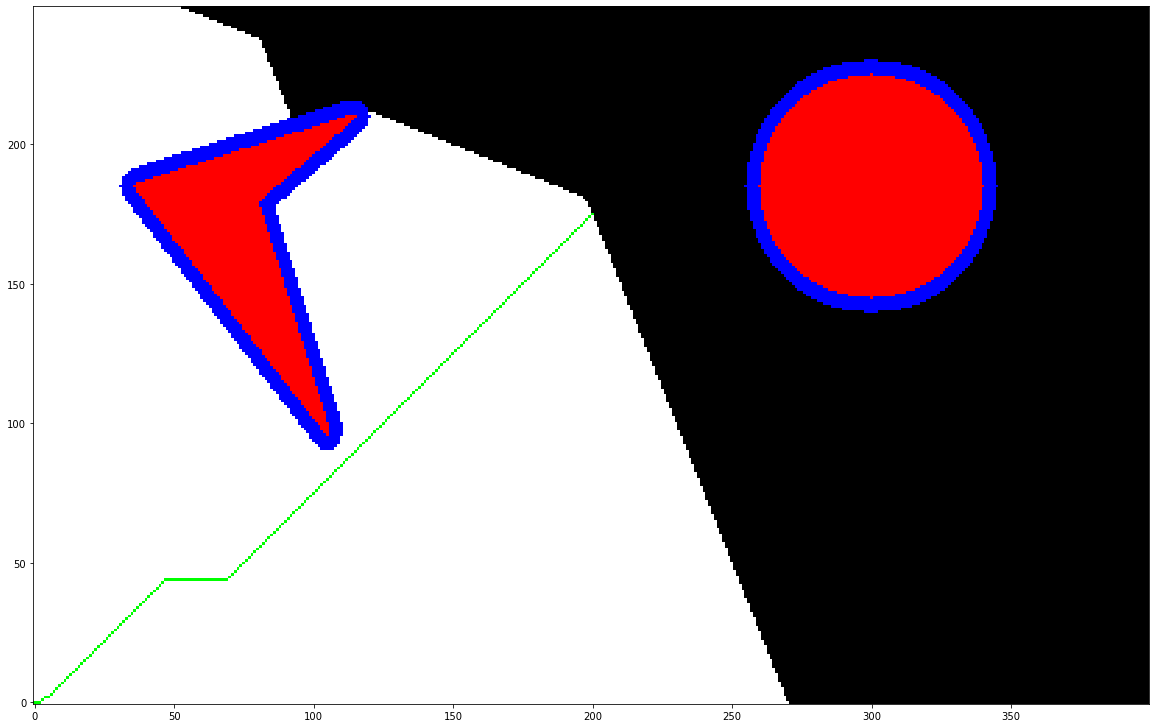

In [558]:
fig, ax = plt.subplots(figsize = (20, 20))

ax.imshow(color_map, origin = 'bottom')